In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib.pyplot import figure

Data from https://www.kaggle.com/aceofit/stockmarketdatafrom1996to2020

In [2]:
#importing dataframes
base_location = r'C:/Users/Jonat/Desktop/Springboard/Data/Data/Data/'
tickers = ['AAPL','MSFT','AMZN','GOOG','FB','IBM','DIS','NFLX','CMCSA','ORCL','CERN','VZ']
dataframes_dict = {}
for ticker in tickers:
    temp = pd.read_csv(base_location+ticker+'/'+ticker+'.csv',parse_dates=['Date'],index_col='Date')
    #temp.index = pd.DatwraetimeIndex(temp.index).to_period('D')
    dataframes_dict[ticker] = temp


In [3]:
dataframes_dict['AAPL'].info()
dataframes_dict['MSFT'].info()
dataframes_dict['AMZN'].info()
dataframes_dict['GOOG'].info()
dataframes_dict['FB'].info()
dataframes_dict['IBM'].info()
dataframes_dict['DIS'].info()
dataframes_dict['NFLX'].info()
dataframes_dict['CMCSA'].info()
dataframes_dict['ORCL'].info()
dataframes_dict['CERN'].info()
dataframes_dict['VZ'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6193 entries, 1996-01-02 to 2020-08-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6193 non-null   float64
 1   High       6193 non-null   float64
 2   Low        6193 non-null   float64
 3   Close      6193 non-null   float64
 4   Adj Close  6193 non-null   float64
 5   Volume     6193 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 338.7 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6191 entries, 1996-01-02 to 2020-08-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6191 non-null   float64
 1   High       6191 non-null   float64
 2   Low        6191 non-null   float64
 3   Close      6191 non-null   float64
 4   Adj Close  6191 non-null   float64
 5   Volume     6191 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 338.6 KB
<class '

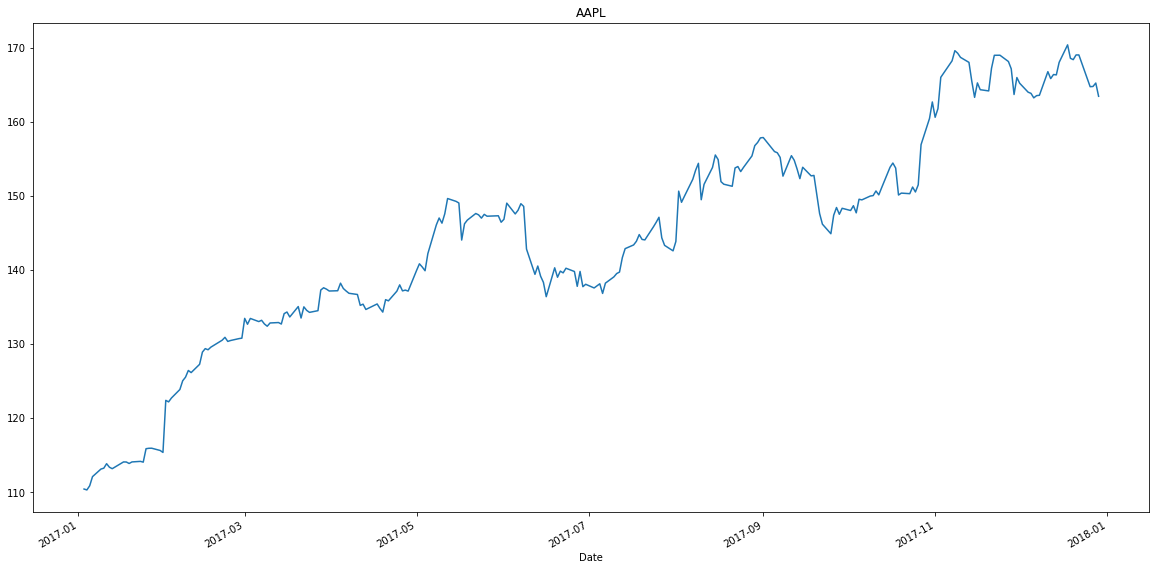

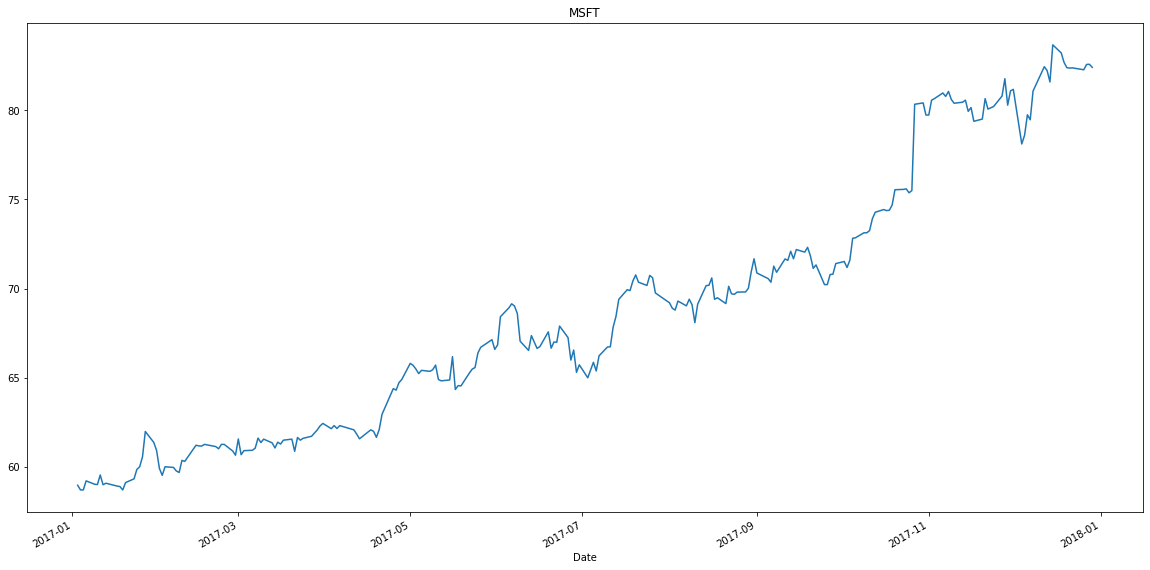

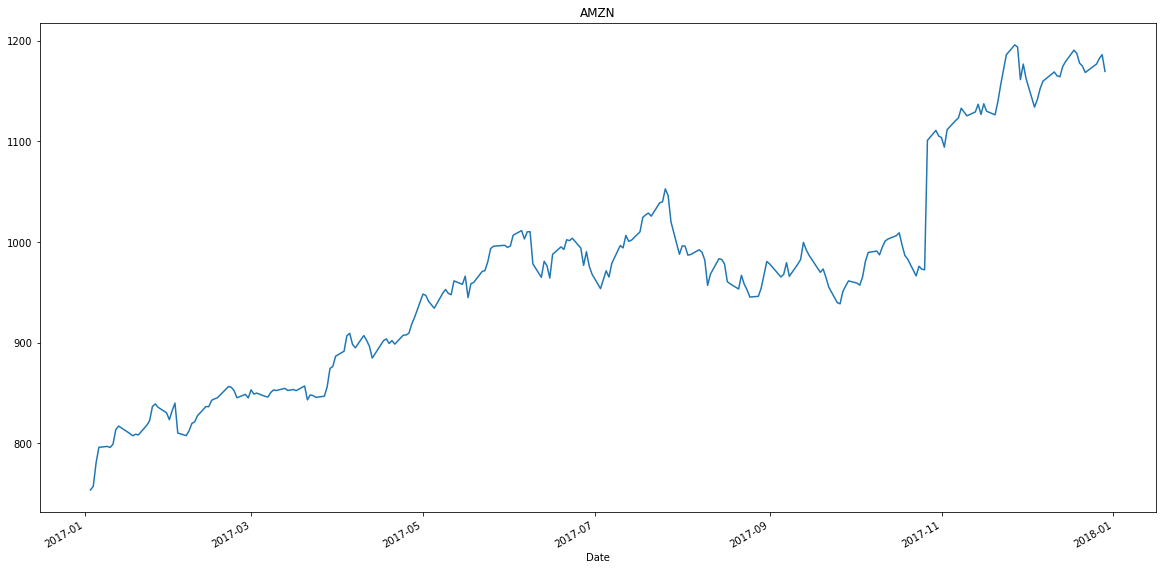

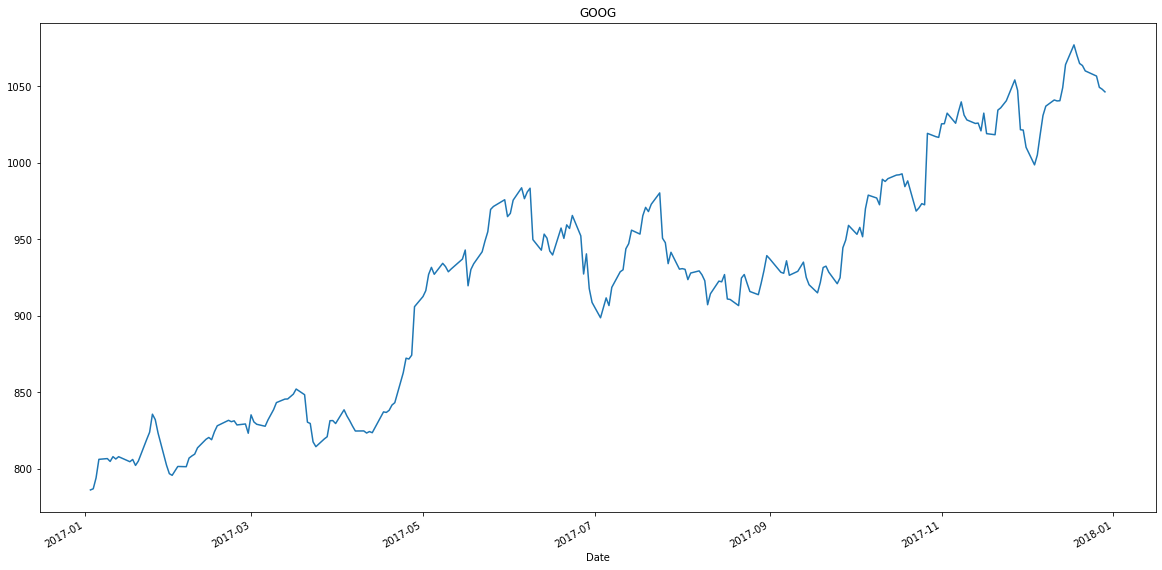

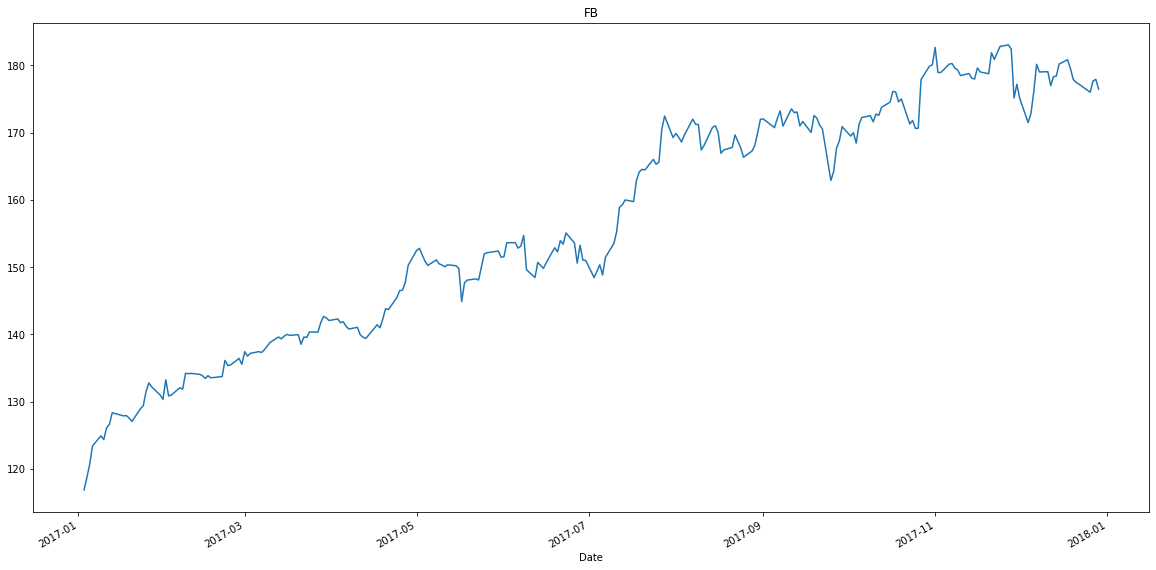

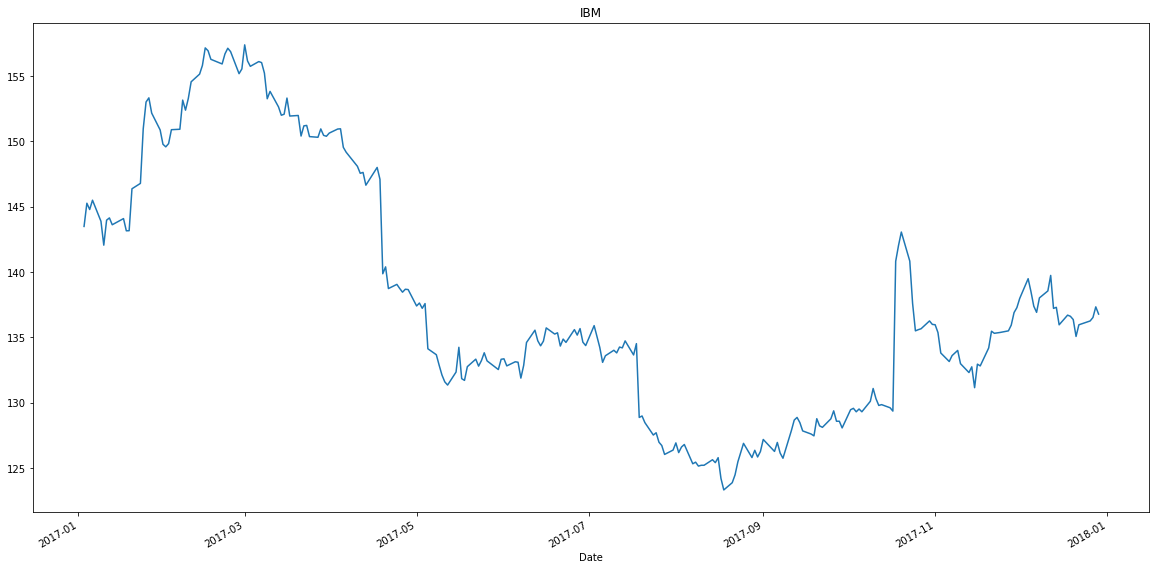

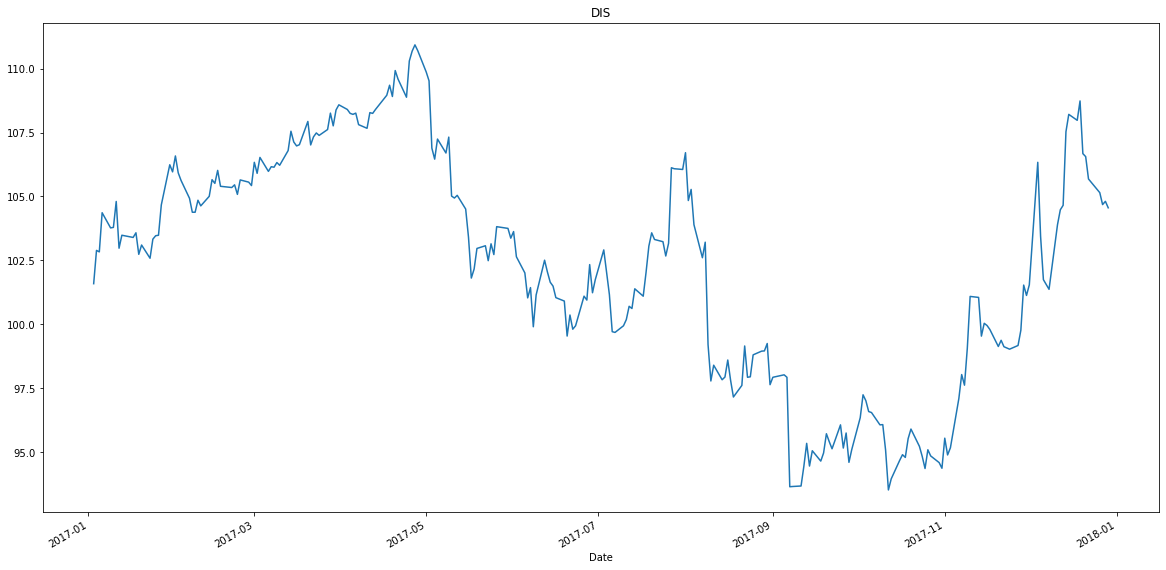

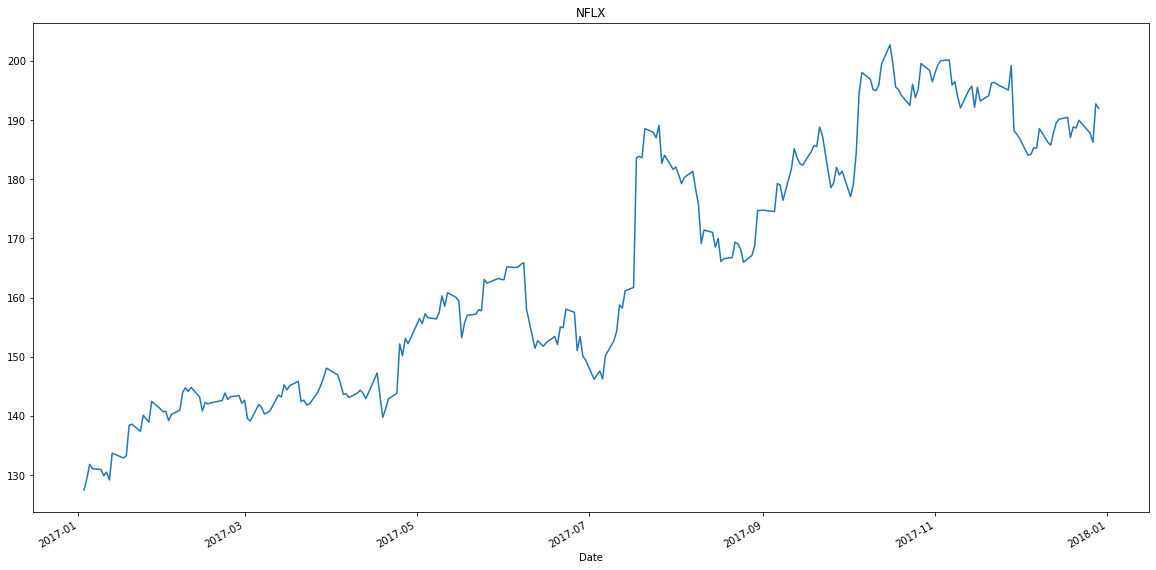

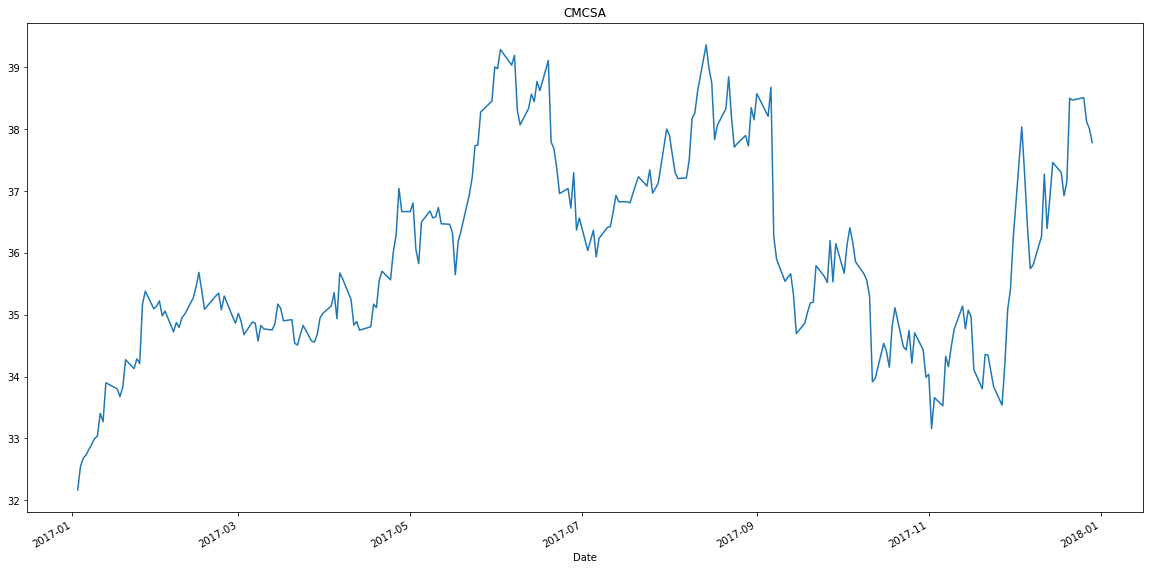

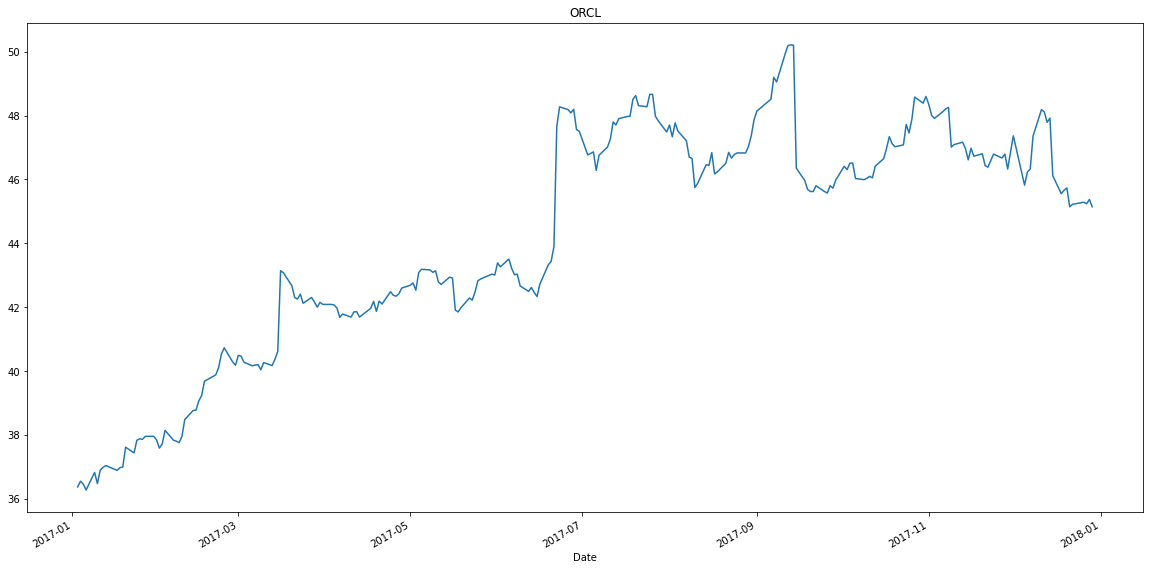

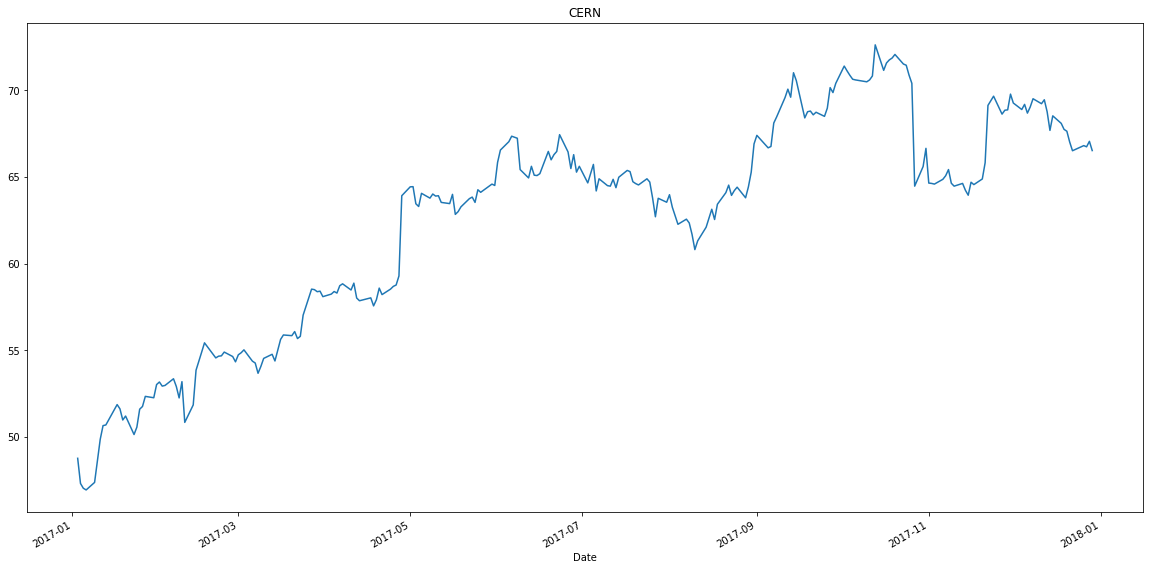

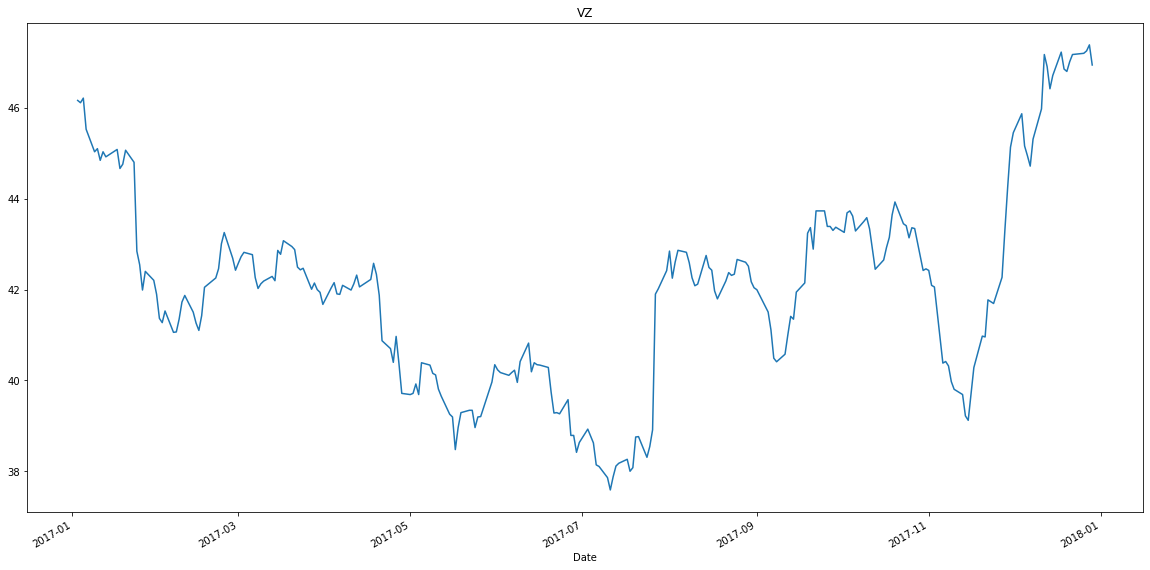

In [4]:
#basic plotting
for ticker in tickers:
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    plt.title(ticker)
    dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-12-31'].plot(ax=ax)


For Time Series Analysis we like the data to be stationary. Most stock data (as we will see) is not stationary but follows a Random Walk (with Drift). We will be checking to see if the data is a Random Walk and if it is, we will be converting it to make it weak-stationary (mean,variance,autocorrelations not time dependent) like White Noise which is stationary.

In [5]:
#Random Walk test: Dikcey-Fuller test. To test if series is a Random Walk. Null hypothesis is that series is a random walk
#and if p-value if less than .05 we can reject the null hypotheses that the series is a random walk with with 95% confidence
from statsmodels.tsa.stattools import adfuller
for ticker in tickers:
    adfuller_test = adfuller(dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-12-31'])
    #p-value
    print(ticker,'adfuller_test p-value is',adfuller_test[1])
    if adfuller_test[1] < .05:
        print(ticker,'95% confidence stationary')

AAPL adfuller_test p-value is 0.3210366319207346
MSFT adfuller_test p-value is 0.9493767745646526
AMZN adfuller_test p-value is 0.7194591445269073
GOOG adfuller_test p-value is 0.7301247080886414
FB adfuller_test p-value is 0.26366169344922225
IBM adfuller_test p-value is 0.6702496661966206
DIS adfuller_test p-value is 0.4437274907487811
NFLX adfuller_test p-value is 0.5526354163116555
CMCSA adfuller_test p-value is 0.06016776910329916
ORCL adfuller_test p-value is 0.2155061107542266
CERN adfuller_test p-value is 0.23294913090078656
VZ adfuller_test p-value is 0.2101339139567483


We can see that the data is not stationary with 95% confidence. CMCSA does come close.

AAPL 95% confidence stationary
MSFT 95% confidence stationary
AMZN 95% confidence stationary
GOOG 95% confidence stationary
FB 95% confidence stationary
IBM 95% confidence stationary
DIS 95% confidence stationary
NFLX 95% confidence stationary
CMCSA 95% confidence stationary
ORCL 95% confidence stationary
CERN 95% confidence stationary
VZ 95% confidence stationary


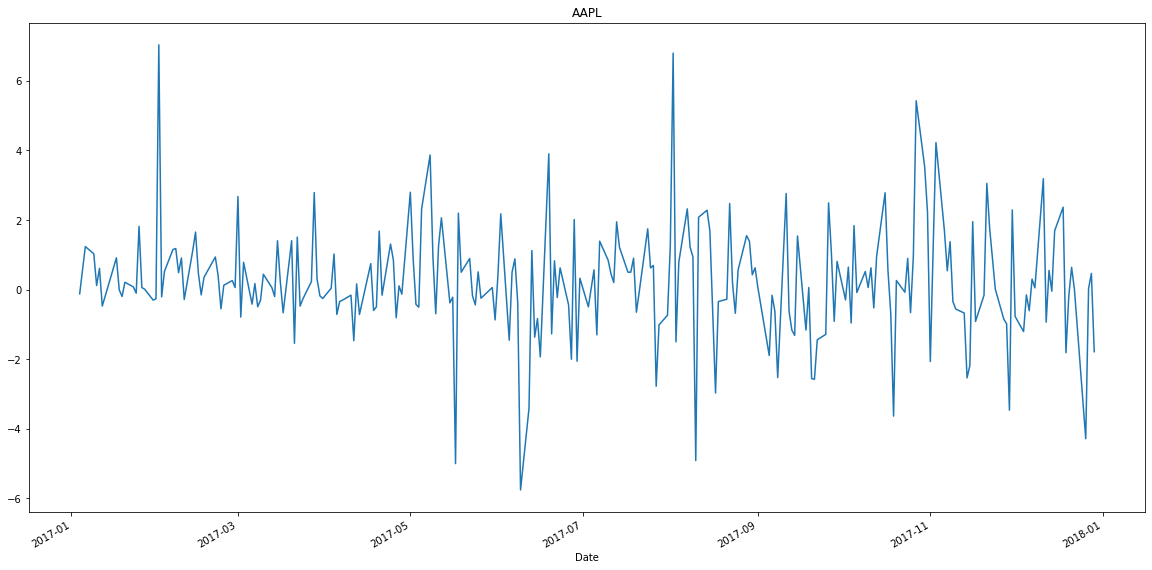

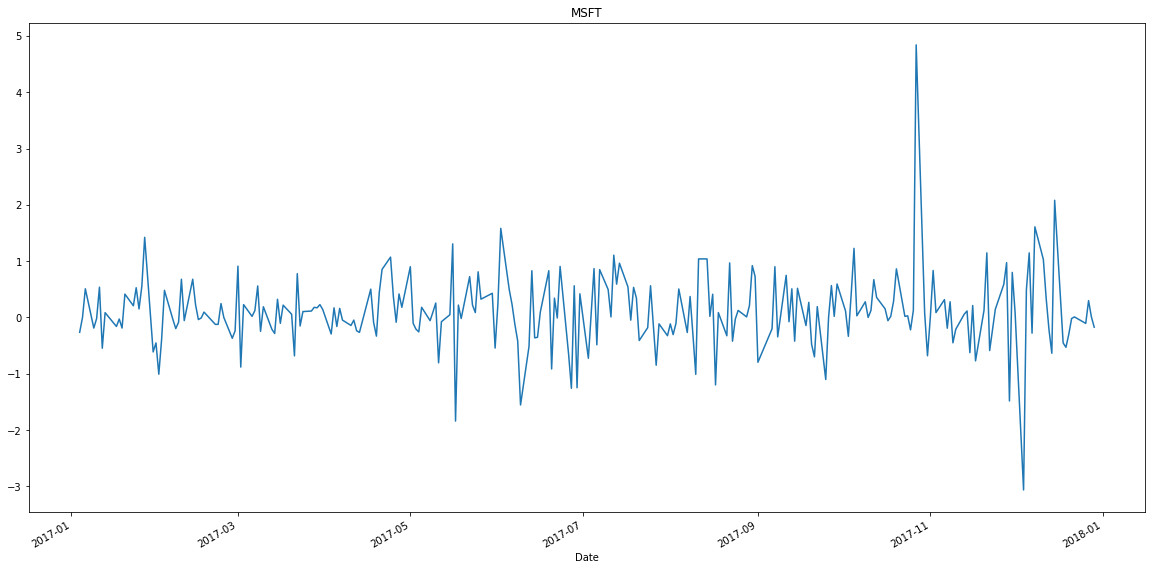

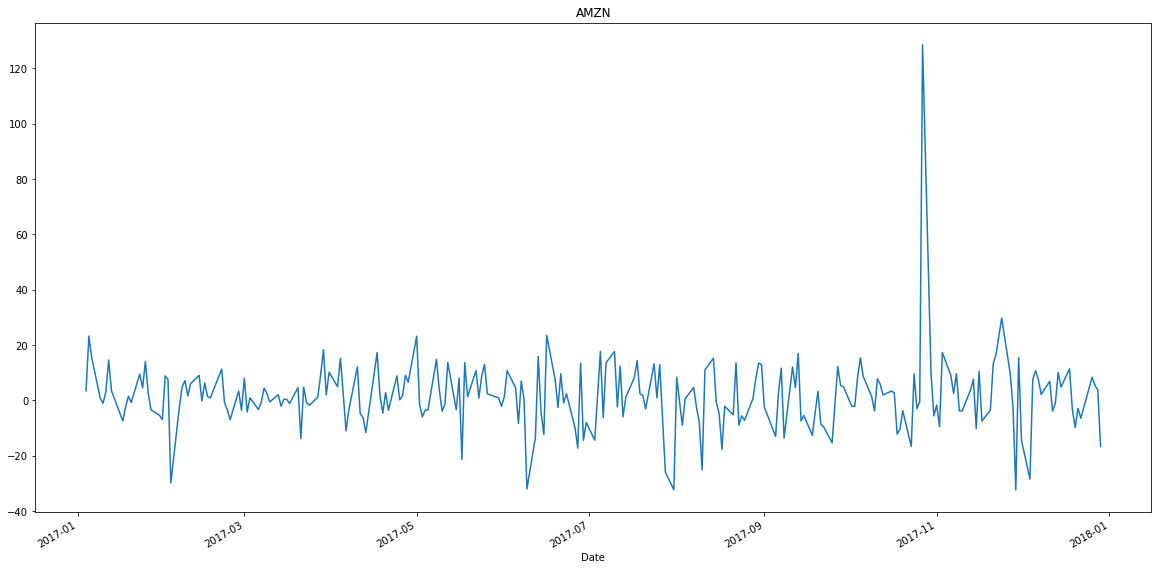

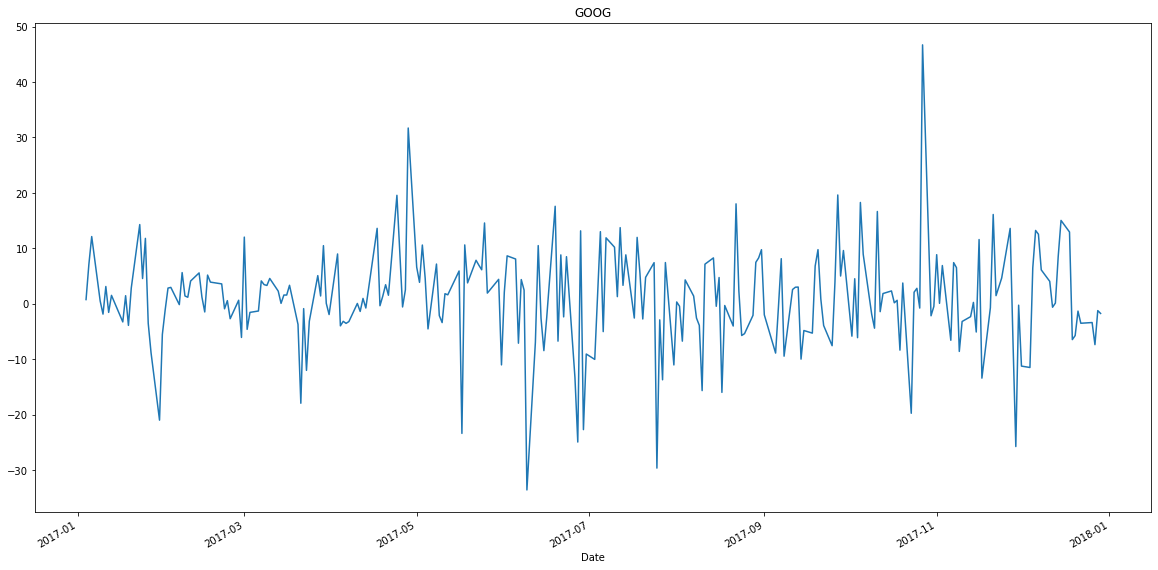

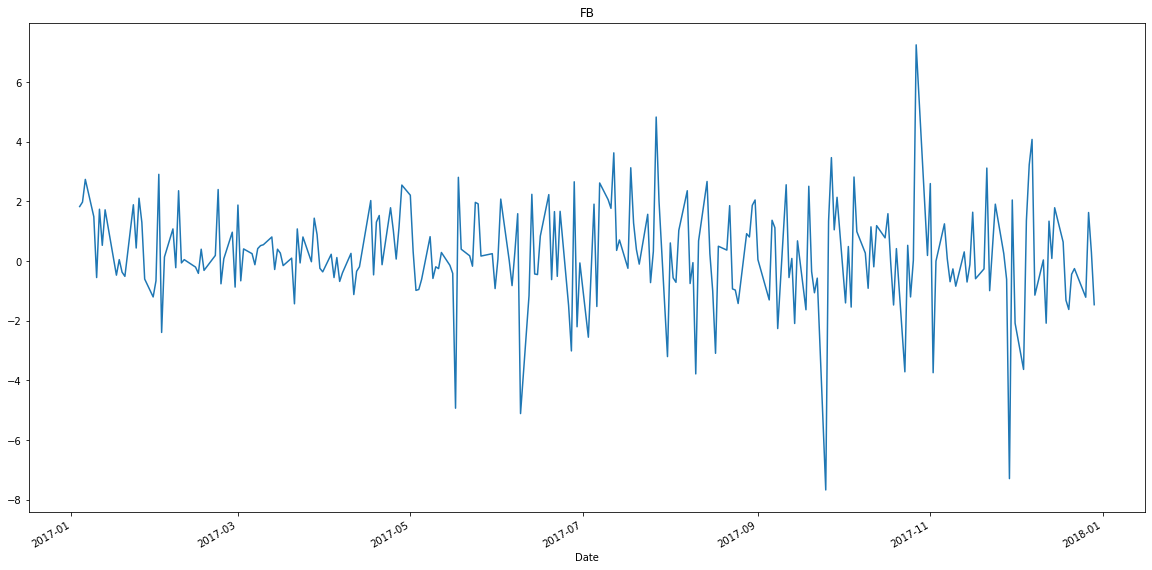

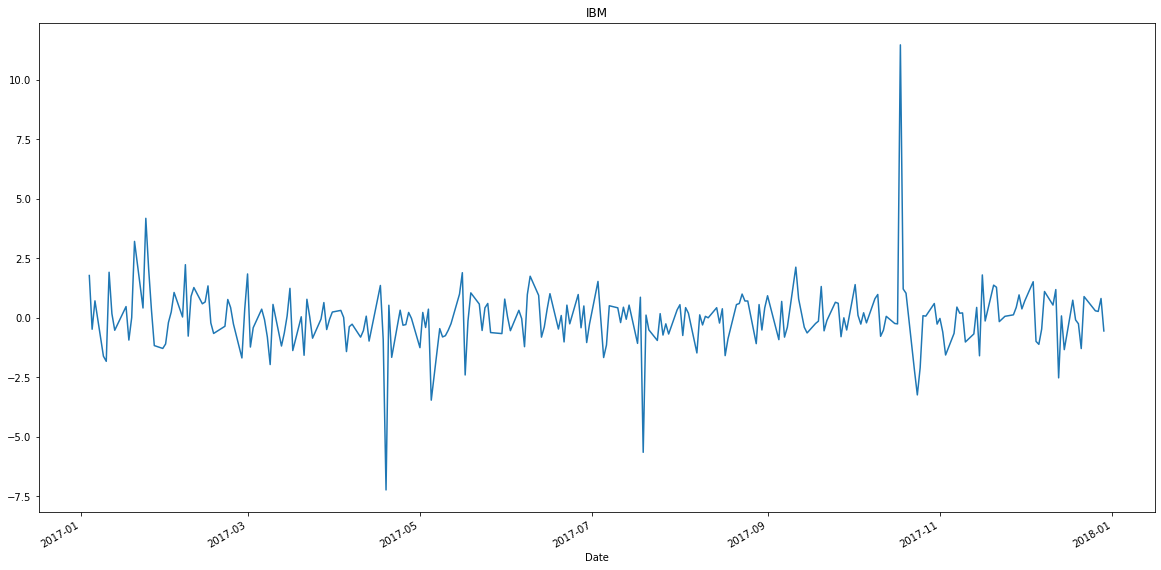

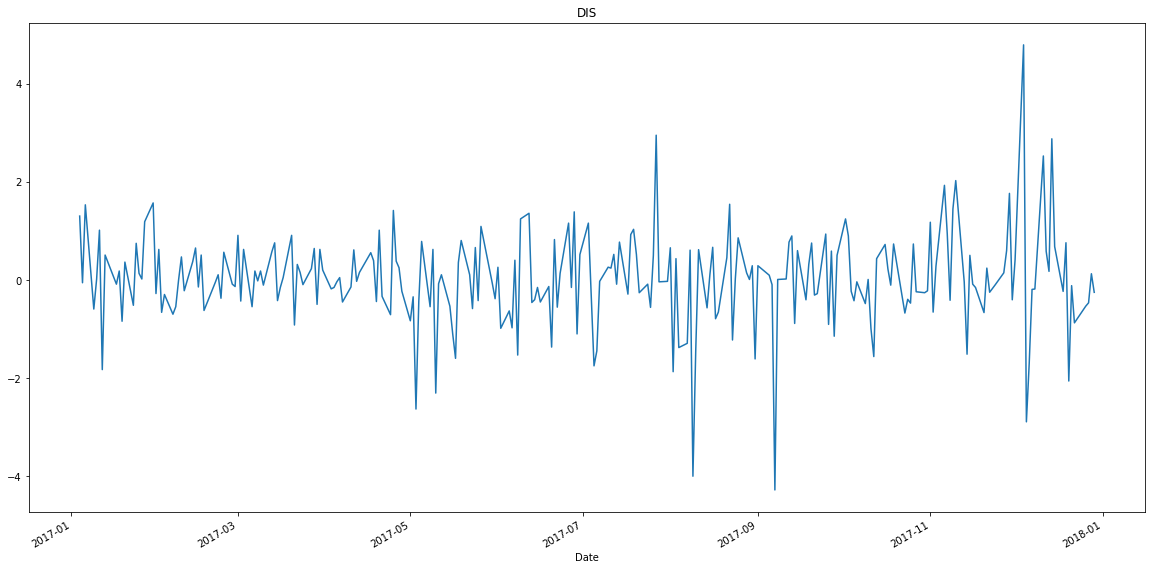

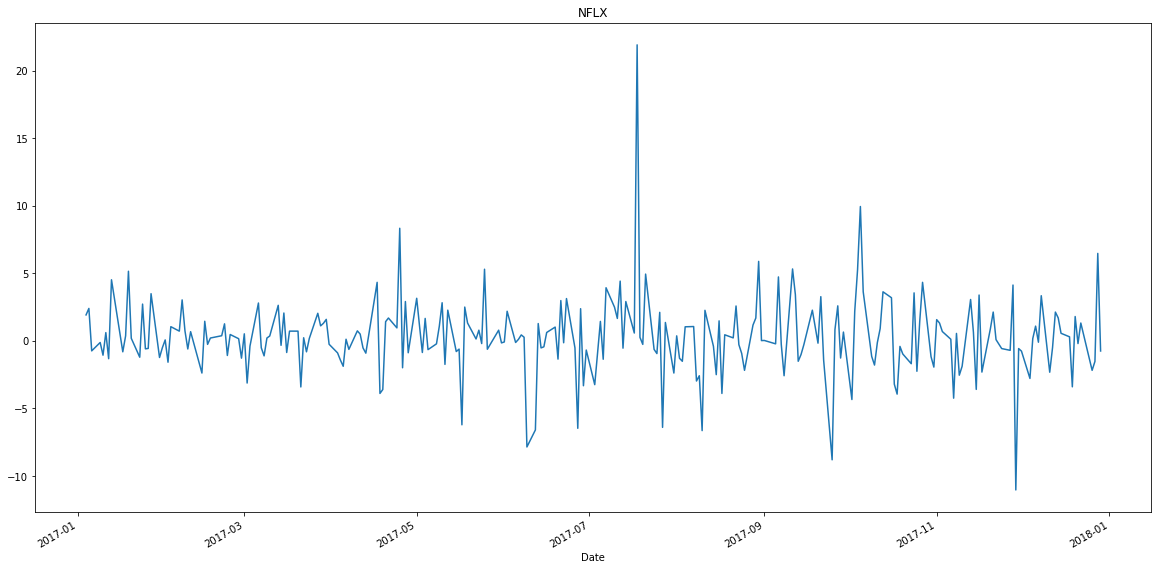

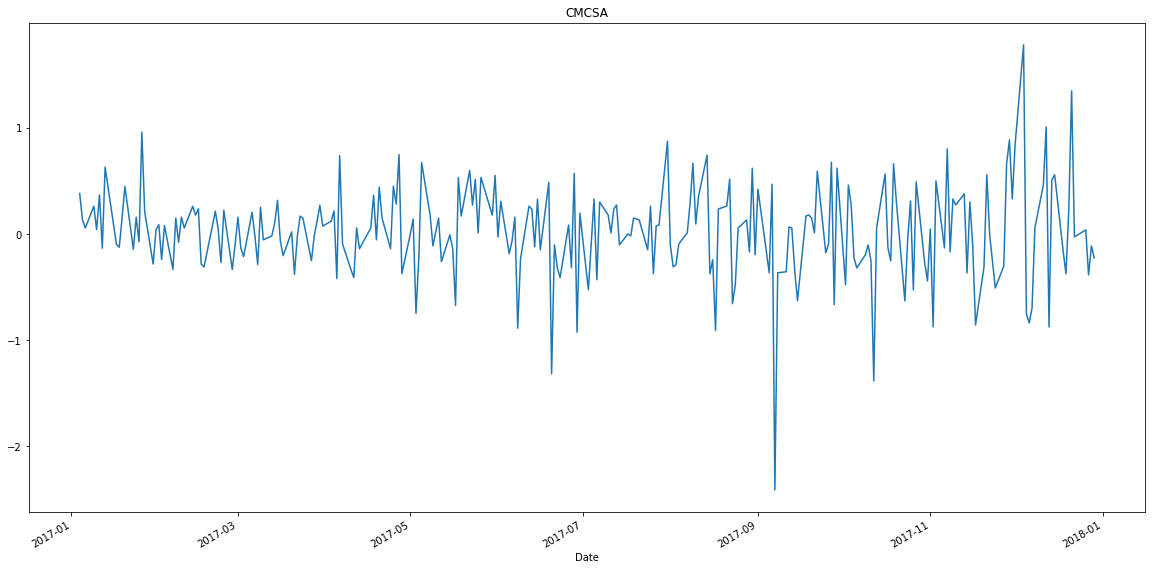

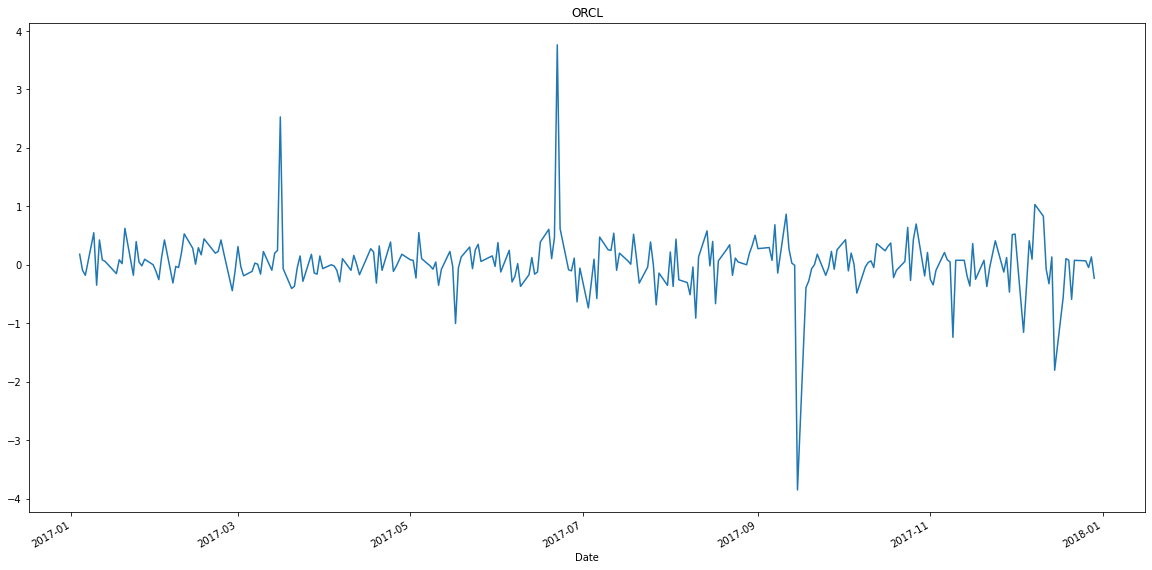

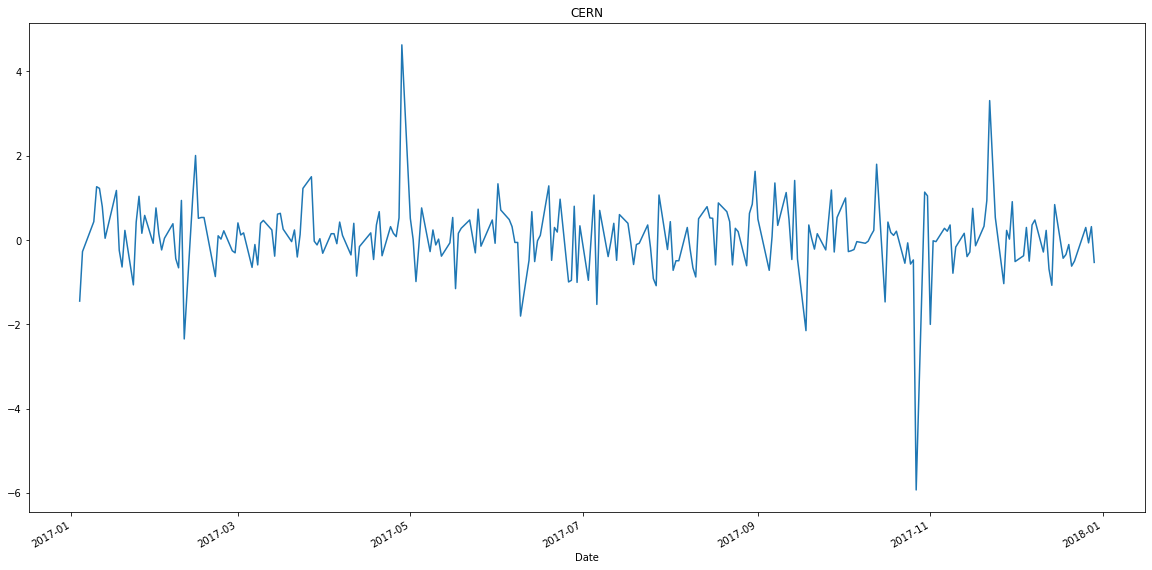

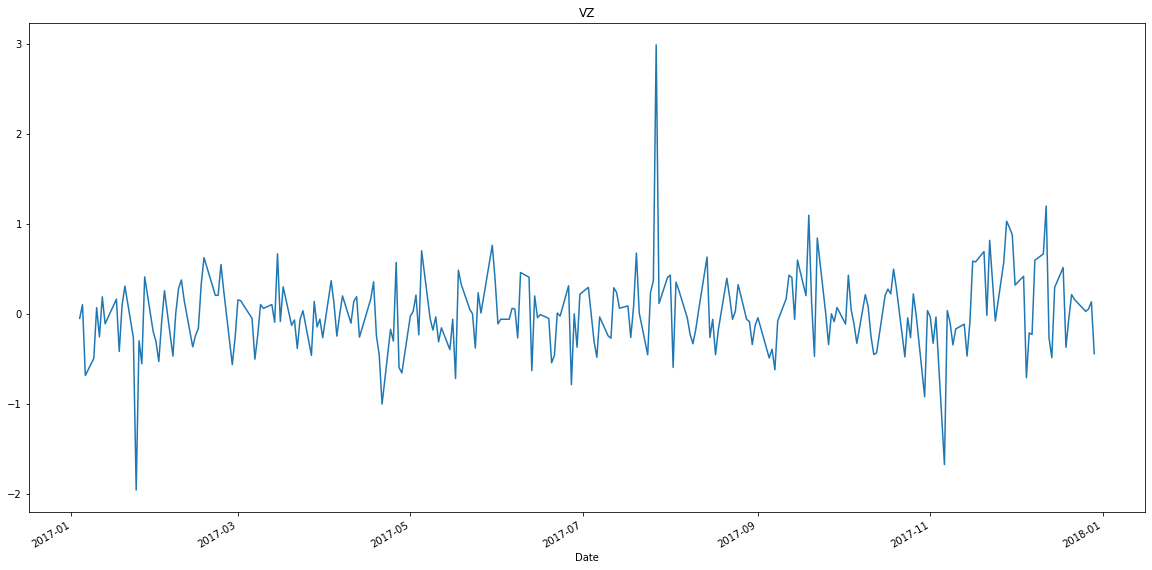

In [6]:
#A good way to make data stationary is to take the first or second differences. In the SARIMAX and Prophet models this will be done automatically
#as part of the function but we will show the graphs for stationary here. 
for ticker in tickers:
    adfuller_test = adfuller(dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-12-31'].diff().dropna())
    #p-value
    if adfuller_test[1] < .05:
        print(ticker,'95% confidence stationary')
    else:
        print(ticker,'Still not stationary')
        
for ticker in tickers:
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    plt.title(ticker)
    dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-12-31'].diff().dropna().plot(ax=ax)        


We can see that taking the first differences made the data stationary with 95% confidence. 

Using the ACF and PACF we can attempt to choose a model order and determine the seasonal trend.
*	If the amplitude of the ACF tails off as lags increase and the PACF cuts off after some lag (p), then we have an AR p model. Meaning AR p will be the maximum goodness of the ARIMA.
*	If the amplitude of the ACF cuts off after some lag (q) and the PACF tails off, then we have a MA q model. (Tailing off is allowed to switch positive and negative as long as decreasing). Meaning the MA q will be the maximum goodness of the ARIMA. 
*	If both the ACF and the PACF tail off then we have an ARMA model and we can’t deduce the model orders of p and q. 
*	The ACF and PCAF plots need to be performed on stationary data!
*	If the Autocorrelation at lag-1 is very negative it’s a sign that we have taken the difference too many times. 

The ACF point that sticks out the most is usually the seasonal trend

C:\Users\Jonat\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\Jonat\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\Jonat\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

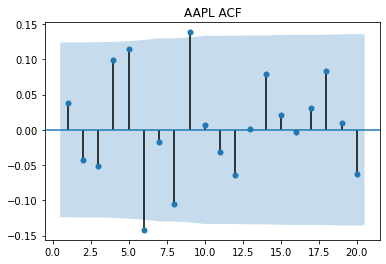

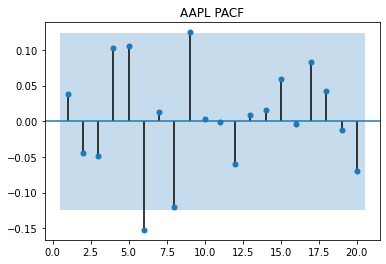

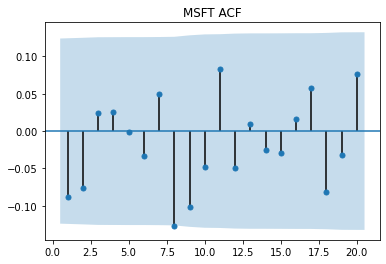

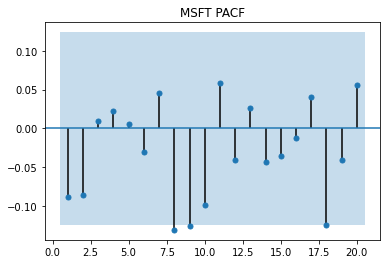

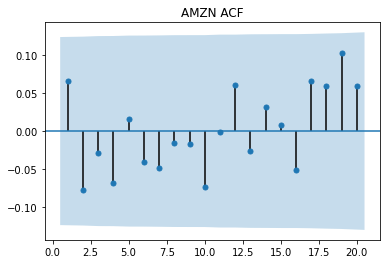

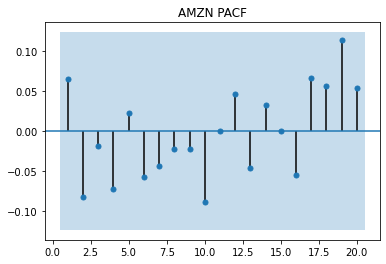

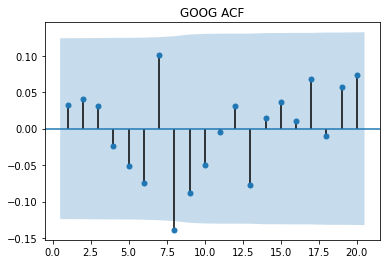

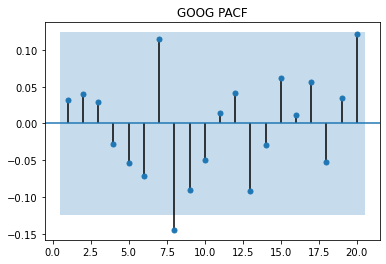

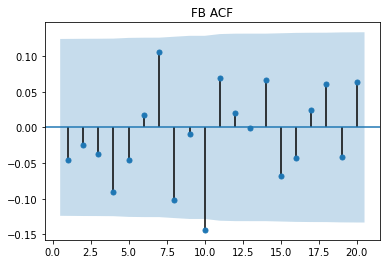

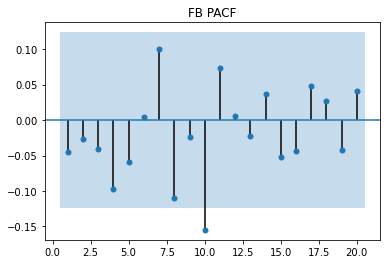

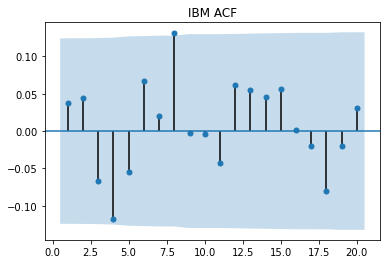

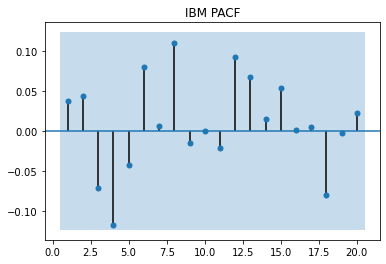

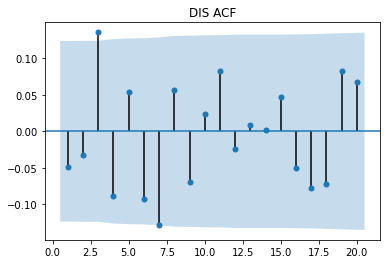

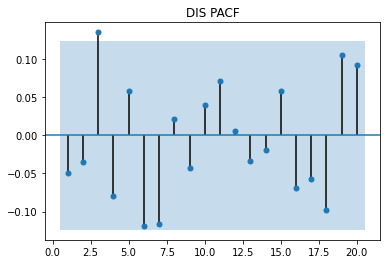

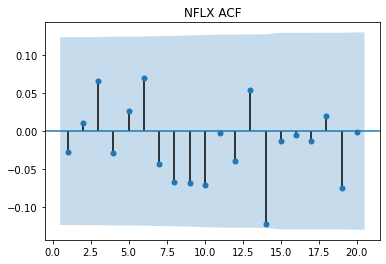

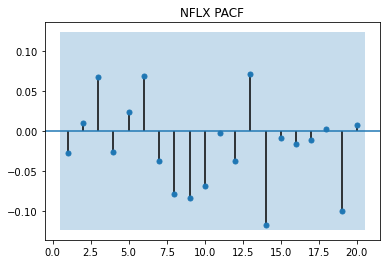

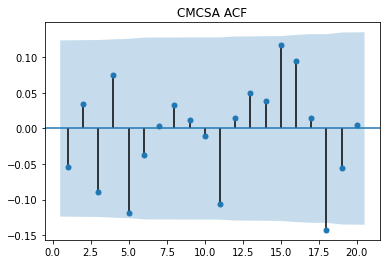

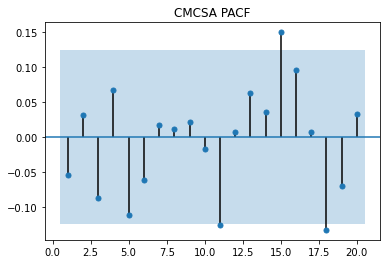

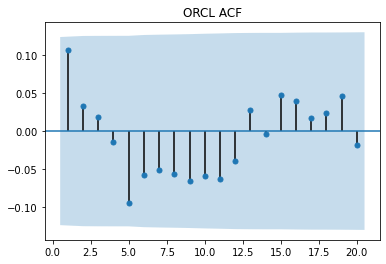

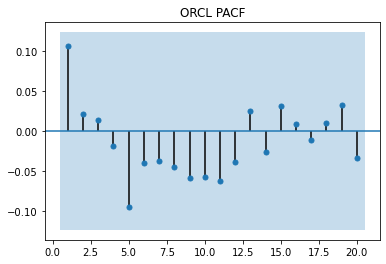

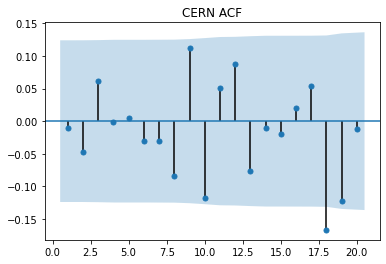

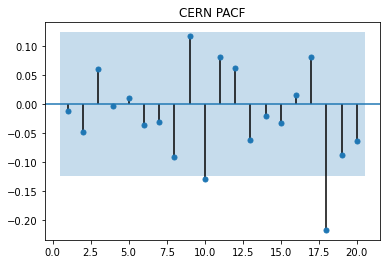

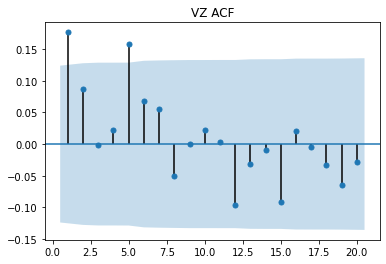

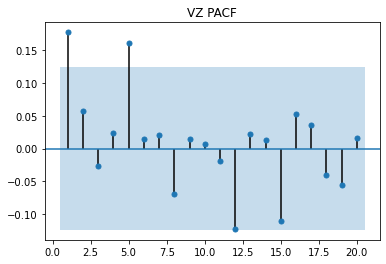

In [7]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

for ticker in tickers:
    plot_acf(dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-12-31'].diff().dropna(),lags=20,alpha=.05,zero=False,title=ticker+' ACF')
    plot_pacf(dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-12-31'].diff().dropna(),lags=20,alpha=.05,zero=False,title=ticker+' PACF')

The ACF and PACF almost mirror eachother and we won't be able to determine a good AR or MA from them.
We also don't have a good indication on the seasonal trend. This is common with stock data.

We will check the best AR, MA, Difference, and seasonal order using the AIC metric.
There is a handy library called pmdarima which is fantastic at returning the best SARIMAX parameters.

Our desire is that both of the null hypothesies stand.
*   Prob(Q): is the p-value for null hypotheses that the residuals have no correlation.
*    Prob(JB): is the p-value for null hypotheseis that residulas are normal distriubuted. 

In [8]:
import pmdarima as pm

In [9]:
sarimax_dict = {}
for ticker in tickers:
    model = pm.auto_arima(dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-12-31'],start_p=1,d=1,start_q=1,max_p=10,max_q=10,max_order=10,information_criterion='aic',stepwise=False)
    sarimax_dict[ticker] = model

In [10]:
for ticker in tickers:
    print(ticker,sarimax_dict[ticker],sarimax_dict[ticker].aic())

AAPL  ARIMA(5,1,1)(0,0,0)[1] intercept 947.5809788640615
MSFT  ARIMA(0,1,1)(0,0,0)[1] intercept 508.0495145702148
AMZN  ARIMA(0,1,0)(0,0,0)[1] intercept 1991.677448695616
GOOG  ARIMA(2,1,4)(0,0,0)[1] intercept 1812.360285874522
FB  ARIMA(1,1,1)(0,0,0)[1] intercept 982.6993301492139
IBM  ARIMA(0,1,0)(0,0,0)[1] intercept 863.505651386329
DIS  ARIMA(4,1,6)(0,0,0)[1] intercept 695.404177167356
NFLX  ARIMA(0,1,0)(0,0,0)[1] intercept 1249.4419098315143
CMCSA  ARIMA(0,1,0)(0,0,0)[1] intercept 309.0940688162244
ORCL  ARIMA(1,1,0)(0,0,0)[1] intercept 373.8362899515794
CERN  ARIMA(2,1,1)(0,0,0)[1] intercept 625.8479992935954
VZ  ARIMA(2,1,7)(0,0,0)[1] intercept 297.99602093762553


In [11]:
for ticker in tickers:
    print(ticker,sarimax_dict[ticker].summary())

AAPL                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:               SARIMAX(5, 1, 1)   Log Likelihood                -465.790
Date:                Mon, 13 Sep 2021   AIC                            947.581
Time:                        20:36:29   BIC                            975.753
Sample:                             0   HQIC                           958.919
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3333      0.193      1.729      0.084      -0.045       0.711
ar.L1         -0.7902      0.099     -7.986      0.000      -0.984      -0.596
ar.L2          0.0063      0.094      0.067    

Plotting the diagnostics of the data will show us how well distributed it is.

AAPL Figure(432x288)
MSFT Figure(432x288)
AMZN Figure(432x288)
GOOG Figure(432x288)
FB Figure(432x288)
IBM Figure(432x288)
DIS Figure(432x288)
NFLX Figure(432x288)
CMCSA Figure(432x288)
ORCL Figure(432x288)
CERN Figure(432x288)
VZ Figure(432x288)


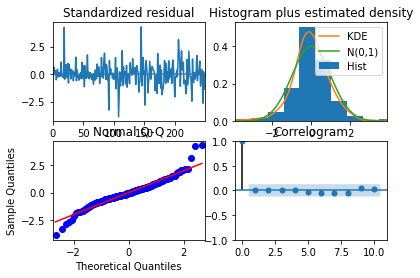

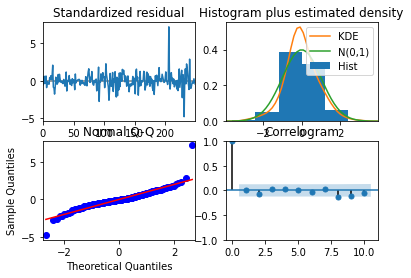

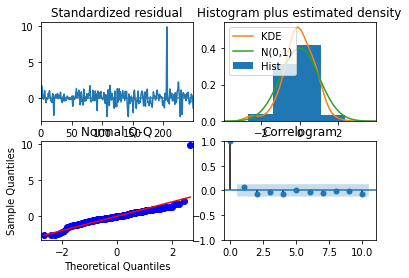

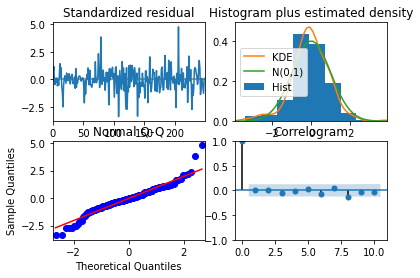

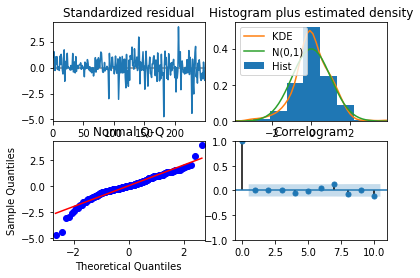

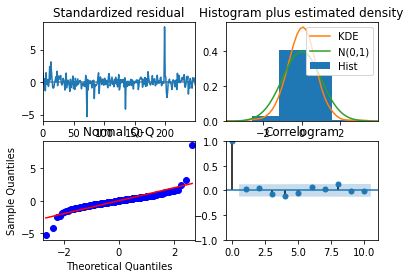

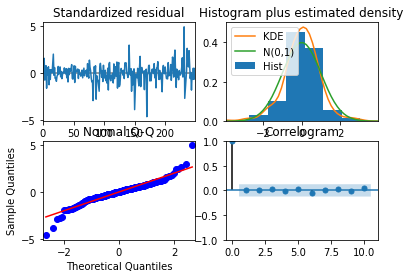

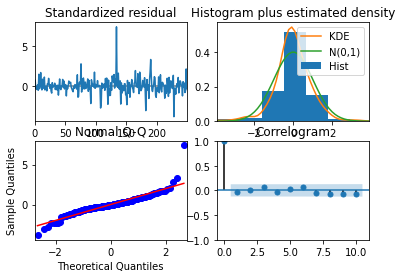

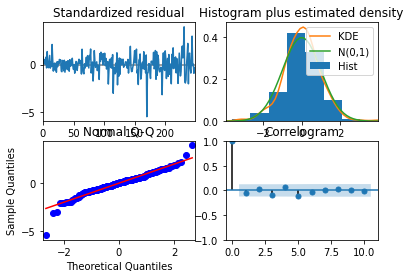

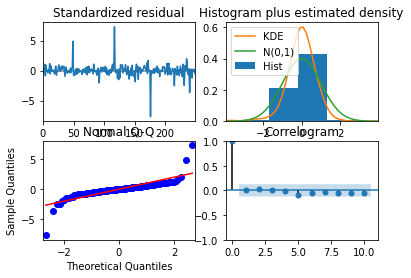

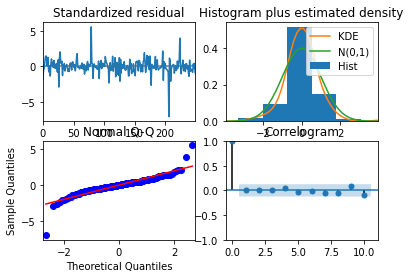

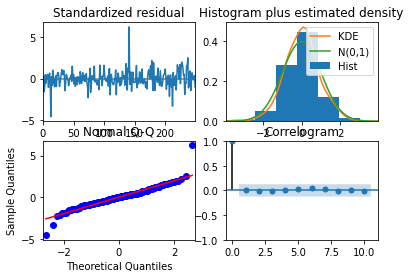

In [12]:
for ticker in tickers:
    print(ticker,sarimax_dict[ticker].plot_diagnostics())

Performing metrics on the model will tell us how well the model is compared to the original data. The MAE of the resdiuals will tell us how far our predictions are the the true values. A well fit model will have the resdiuals centered arround 0.

In [13]:
residuals_12 = []
for ticker in tickers:
    residuals = sarimax_dict[ticker].resid()
    residuals_12.append(np.mean(np.abs(residuals)))
    print(ticker,'MAE of the resdiuals',np.mean(np.abs(residuals)))
residuals_12 = np.array(residuals_12)    

AAPL MAE of the resdiuals 1.554609760949899
MSFT MAE of the resdiuals 0.6754743901880099
AMZN MAE of the resdiuals 11.124855253258973
GOOG MAE of the resdiuals 9.43557996957689
FB MAE of the resdiuals 1.6593068540798916
IBM MAE of the resdiuals 1.4038587701195206
DIS MAE of the resdiuals 1.053793800756267
NFLX MAE of the resdiuals 2.420175185705179
CMCSA MAE of the resdiuals 0.4517675916654948
ORCL MAE of the resdiuals 0.4278331687867254
CERN MAE of the resdiuals 0.7382572443637594
VZ MAE of the resdiuals 0.48181588634552736


In [14]:
#MAE and MAPE
from pmdarima.metrics import smape
mape_12 = []
for ticker in tickers:
    mape = smape(dataframes_dict[ticker]['Adj Close']['2018-01-01':'2018-06-01'],sarimax_dict[ticker].predict(105))
    mape_12.append(mape)
    print(ticker,'MAPE of',mape)

AAPL MAPE of 3.6900070670858147
MSFT MAPE of 3.264132110786443
AMZN MAPE of 15.632255825601174
GOOG MAPE of 6.851291363325327
FB MAPE of 9.88119691521156
IBM MAPE of 3.7406138285937973
DIS MAPE of 5.888166475279302
NFLX MAPE of 33.889323138873316
CMCSA MAPE of 14.835044409684166
ORCL MAPE of 6.186216126062233
CERN MAPE of 14.44545626674982
VZ MAPE of 5.256913829781965


Using the SARIMAX model we can plot the how well the model does compared to the actual data during that time. 

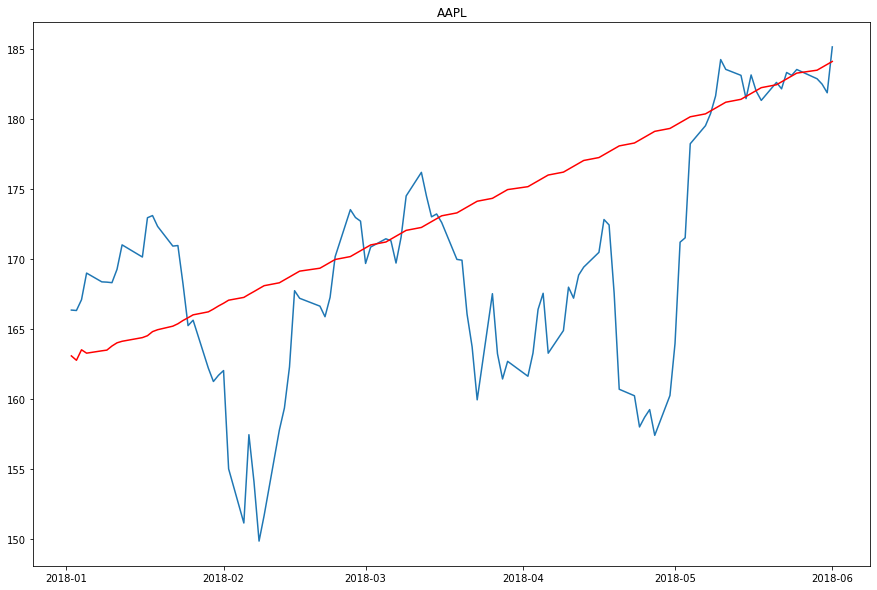

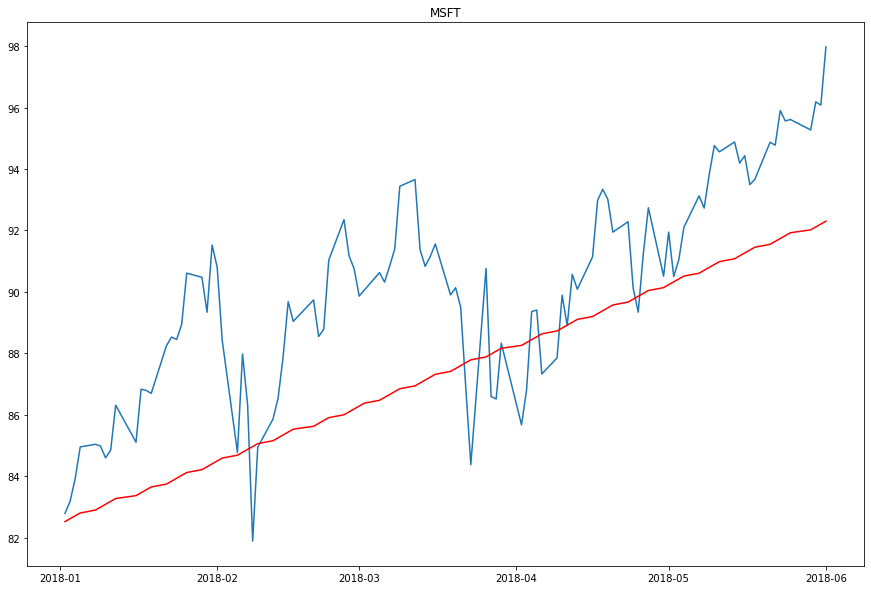

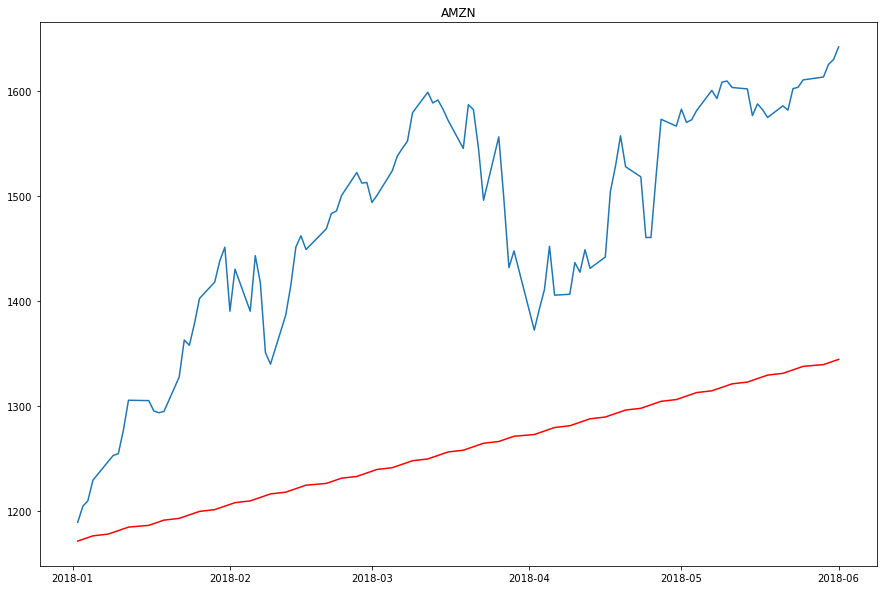

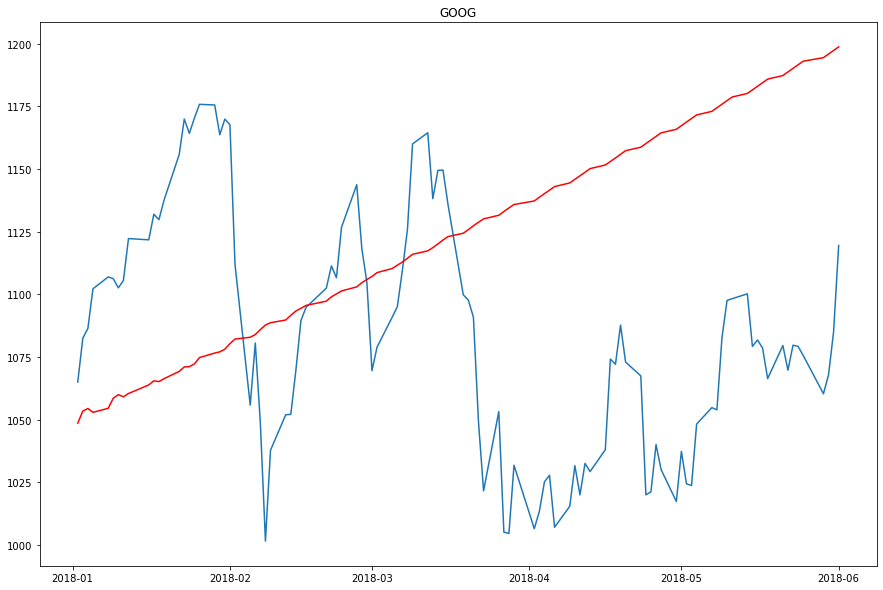

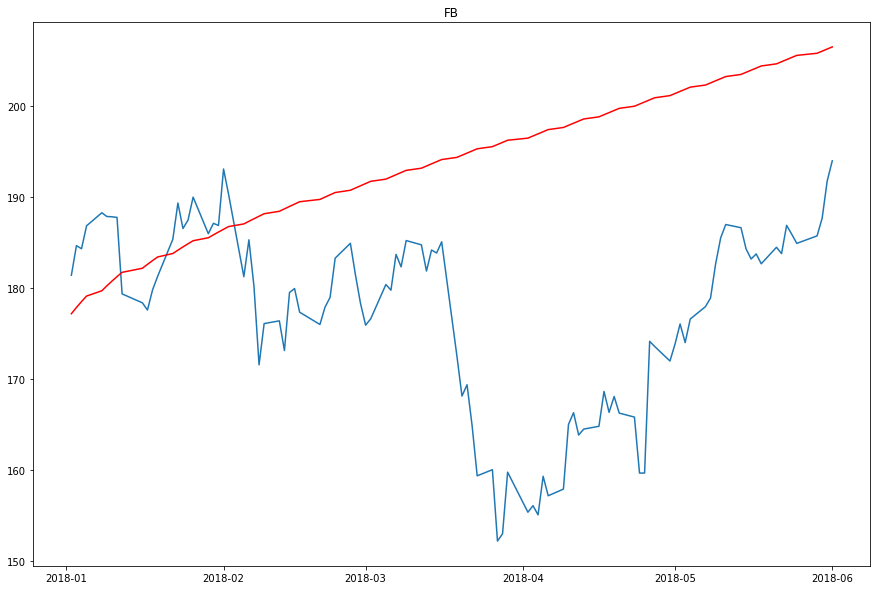

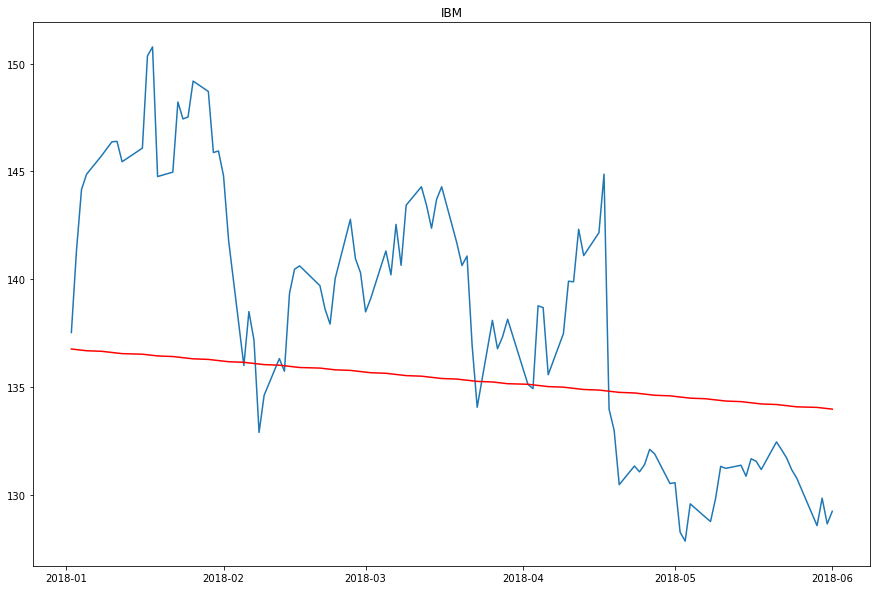

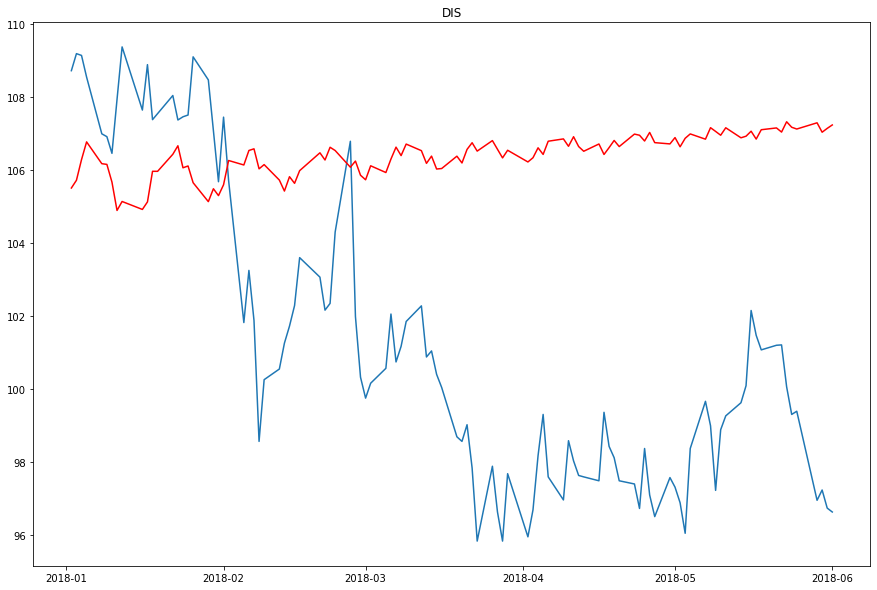

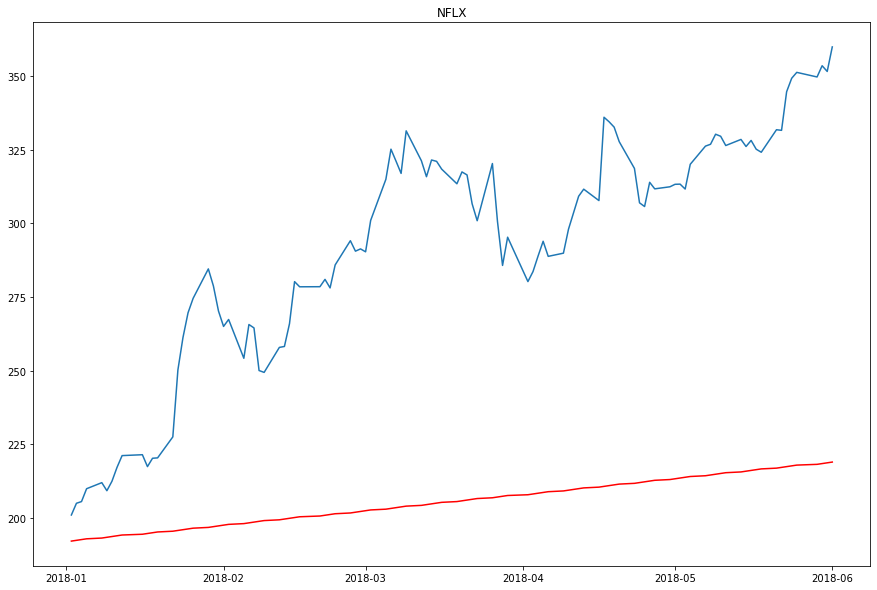

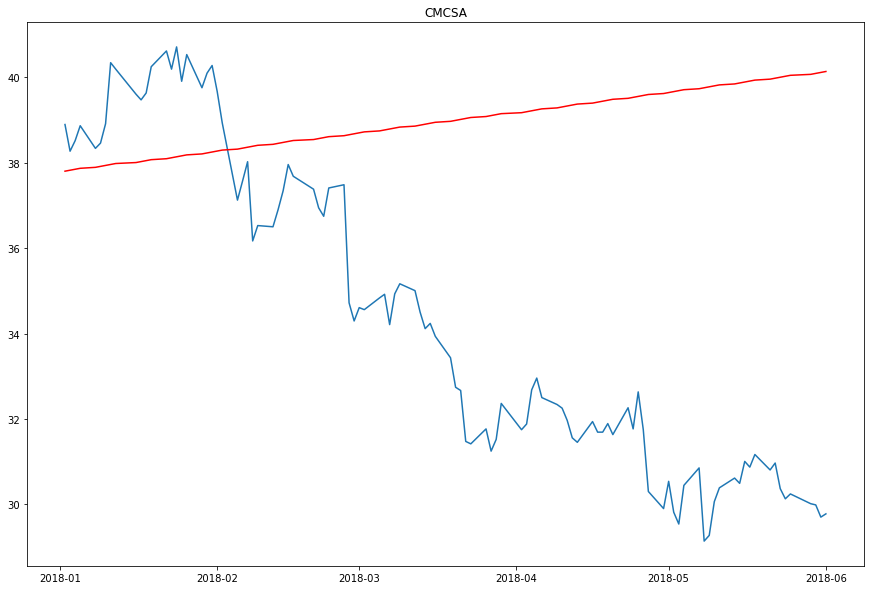

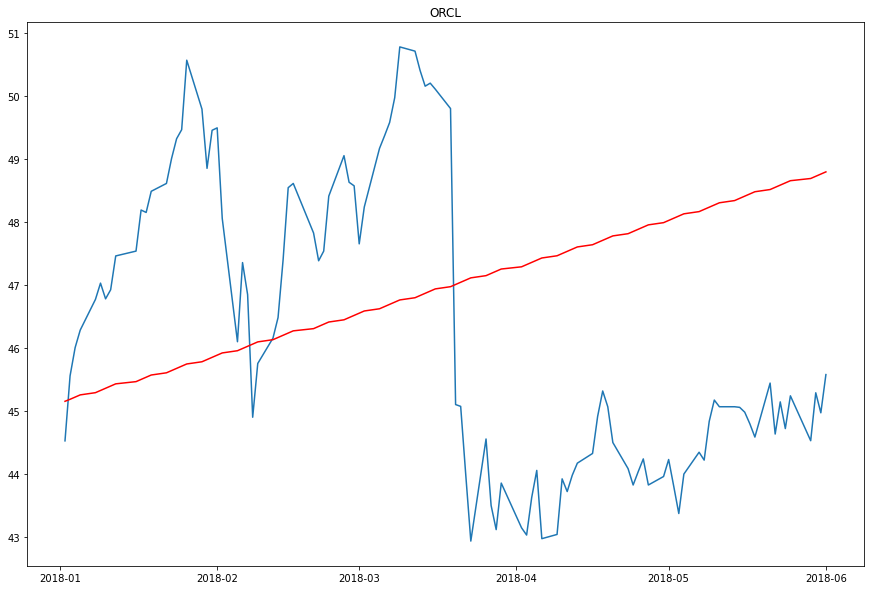

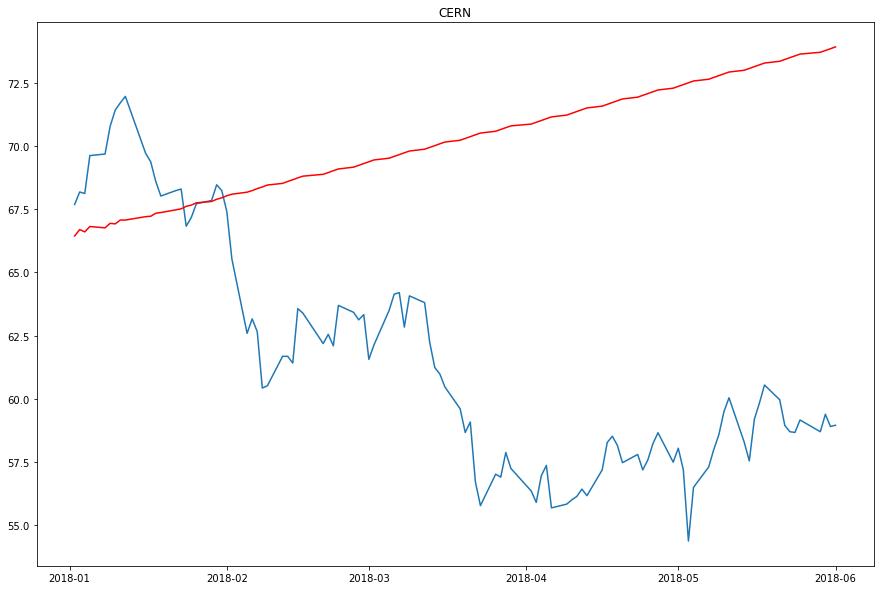

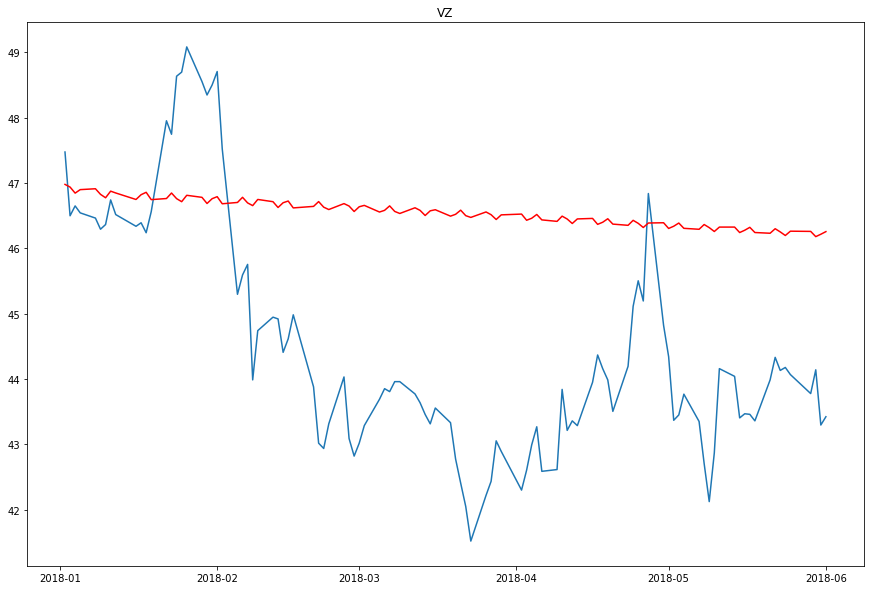

In [15]:
for ticker in tickers:
    plt.figure(figsize=(15,10))
    plt.plot(dataframes_dict[ticker]['Adj Close']['2018-01-01':'2018-06-01'])
    plt.plot(dataframes_dict[ticker]['Adj Close']['2018-01-01':'2018-06-01'].index,sarimax_dict[ticker].predict(105),color='red')
    plt.title(ticker)


As seen by the charts the SARIMAX model didn’t give us good predictions. We will now compare the SARIMAX 12 month data to a 5 month model.

In [16]:
#Random Walk test: Dikcey-Fuller test. To test if series is a Random Walk. Null hypothesis is that series is a random walk
#and if p-value if less than .05 we can reject the null hypotheses that the series is a random walk with with 95% confidence
for ticker in tickers:
    adfuller_test = adfuller(dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-05-31'])
    #p-value
    print(ticker,'adfuller_test p-value is',adfuller_test[1])
    if adfuller_test[1] < .05:
        print(ticker,'95% confidence stationary')

AAPL adfuller_test p-value is 0.5818817432665782
MSFT adfuller_test p-value is 0.8900814253491032
AMZN adfuller_test p-value is 0.990932448117507
GOOG adfuller_test p-value is 0.9857709612669799
FB adfuller_test p-value is 0.13212664415619574
IBM adfuller_test p-value is 0.9514628486201125
DIS adfuller_test p-value is 0.288860686813183
NFLX adfuller_test p-value is 0.8142013177414373
CMCSA adfuller_test p-value is 0.8687054414644553
ORCL adfuller_test p-value is 0.5192249414560177
CERN adfuller_test p-value is 0.8290955836890523
VZ adfuller_test p-value is 0.1689053359334166


C:\Users\Jonat\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\Jonat\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\Jonat\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

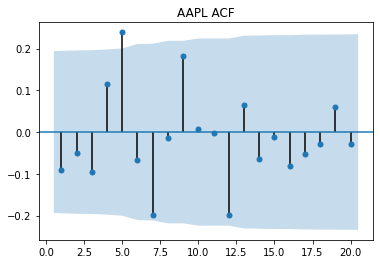

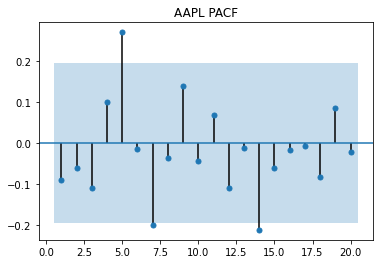

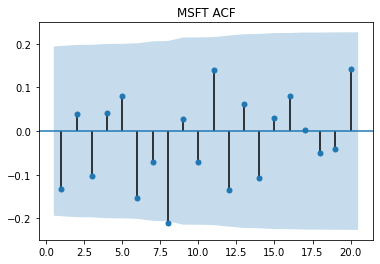

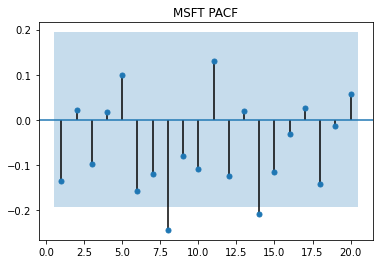

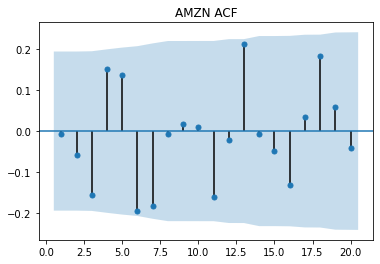

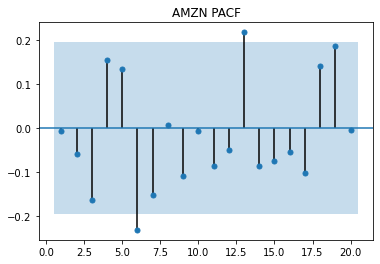

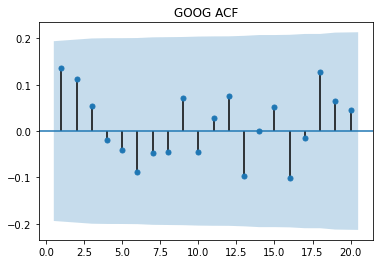

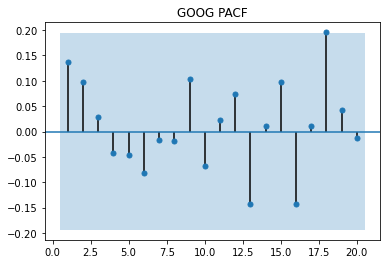

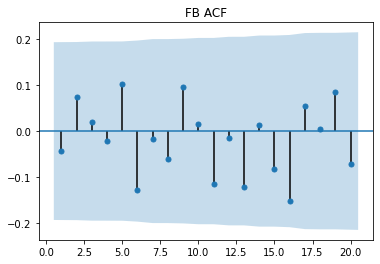

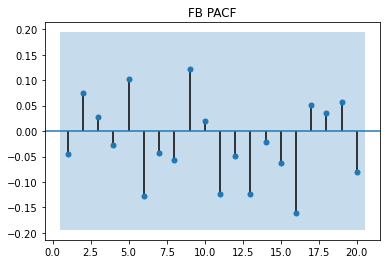

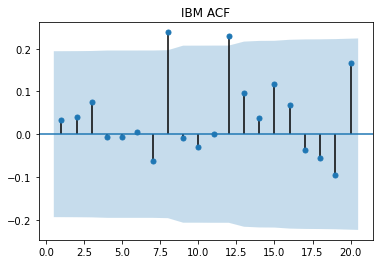

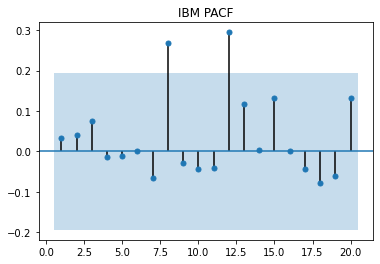

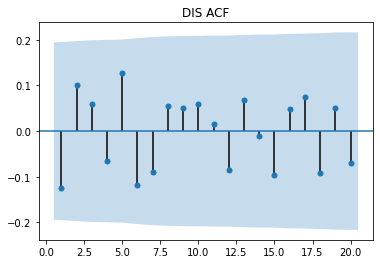

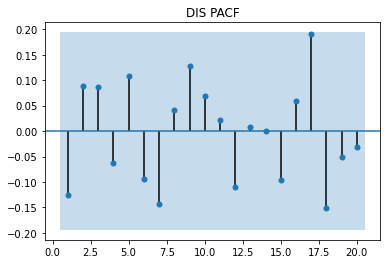

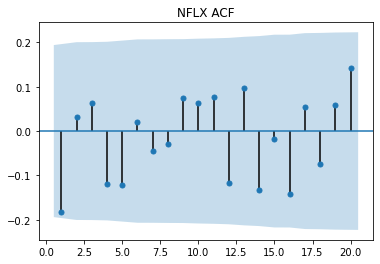

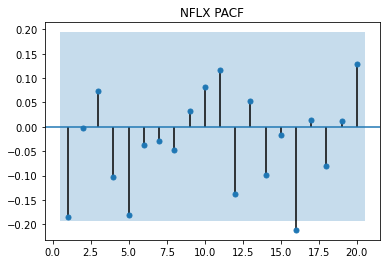

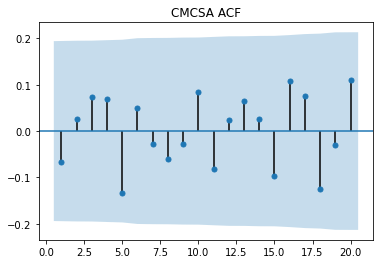

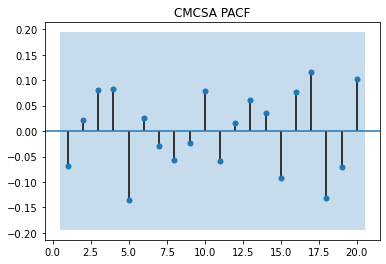

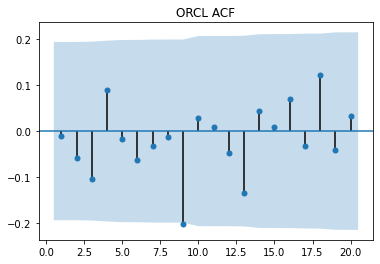

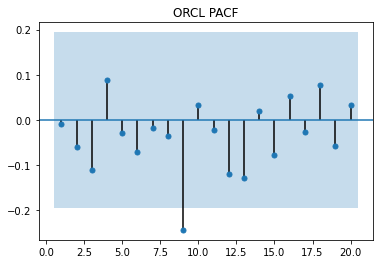

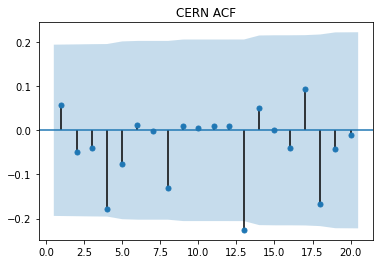

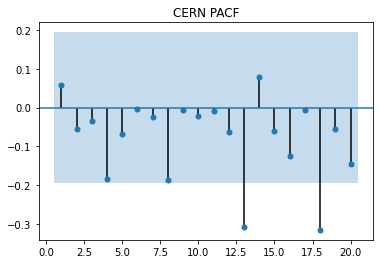

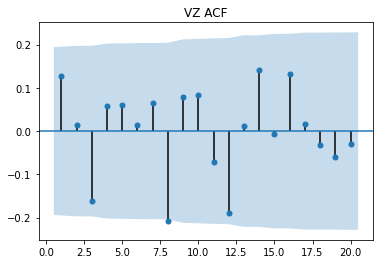

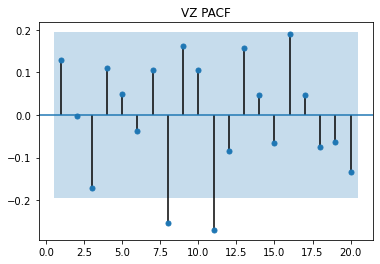

In [17]:
#Exploring the ACF and PCAF charts for the 5-month data

for ticker in tickers:
    plot_acf(dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-05-31'].diff().dropna(),lags=20,alpha=.05,zero=False,title=ticker+' ACF')
    plot_pacf(dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-05-31'].diff().dropna(),lags=20,alpha=.05,zero=False,title=ticker+' PACF')

In [18]:
#Running SARIMAX model on the 5-month data
sarimax_dict_5 = {}
for ticker in tickers:
    model = pm.auto_arima(dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-05-31'],start_p=1,d=1,start_q=1,max_p=10,max_q=10,max_order=10,information_criterion='aic',stepwise=False)
    sarimax_dict_5[ticker] = model

In [19]:
for ticker in tickers:
    print(ticker,sarimax_dict_5[ticker],sarimax_dict_5[ticker].aic())

AAPL  ARIMA(2,1,4)(0,0,0)[1] intercept 338.93288783823033
MSFT  ARIMA(6,1,4)(0,0,0)[1] intercept 136.18784174413332
AMZN  ARIMA(2,1,5)(0,0,0)[1] intercept 719.1991311787999
GOOG  ARIMA(0,1,0)(0,0,0)[1] intercept 696.3997583089349
FB  ARIMA(0,1,0)(0,0,0)[1] intercept 325.380671738556
IBM  ARIMA(0,1,0)(0,0,0)[1] intercept 350.6674136329089
DIS  ARIMA(0,1,0)(0,0,0)[1] intercept 223.119404317305
NFLX  ARIMA(1,1,0)(0,0,0)[1] intercept 433.9855401711908
CMCSA  ARIMA(0,1,0)(0,0,0)[1] intercept 47.1510455398036
ORCL  ARIMA(0,1,0)(0,0,0)[1] intercept 77.92166035719686
CERN  ARIMA(0,1,0)(0,0,0)[1] intercept 236.88318673102245
VZ  ARIMA(8,1,2)(0,0,0)[1] intercept 88.64244373562788


Right away we see that the AIC score is much better in the 5-month data compared to the 12-month data. 

In [20]:
residuals_5 = []
for ticker in tickers:
    residuals = sarimax_dict_5[ticker].resid()
    residuals_5.append(np.mean(np.abs(residuals)))
    print(ticker,'MAE of the resdiuals',np.mean(np.abs(residuals)))
residuals_5 = np.array(residuals_5)

AAPL MAE of the resdiuals 1.850208502173848
MSFT MAE of the resdiuals 0.8845574055895485
AMZN MAE of the resdiuals 12.991692303033316
GOOG MAE of the resdiuals 12.413636650295077
FB MAE of the resdiuals 1.9990780015229401
IBM MAE of the resdiuals 2.2826244874357515
DIS MAE of the resdiuals 1.504655907619083
NFLX MAE of the resdiuals 2.616258604887955
CMCSA MAE of the resdiuals 0.5396868942291628
ORCL MAE of the resdiuals 0.5643047090234153
CERN MAE of the resdiuals 0.9519281229612256
VZ MAE of the resdiuals 0.6862779218756772


In [21]:
mape_5 = []
for ticker in tickers:
    mape = smape(dataframes_dict[ticker]['Adj Close']['2017-06-01':'2017-06-30'],sarimax_dict_5[ticker].predict(22))
    mape_5.append(mape)
    print(ticker,'MAPE of',mape)

AAPL MAPE of 6.242259566702316
MSFT MAPE of 1.5907080211950806
AMZN MAPE of 3.6825869398339957
GOOG MAPE of 3.620912041039399
FB MAPE of 2.3592730170834697
IBM MAPE of 1.7486721437304489
DIS MAPE of 2.248569757633081
NFLX MAPE of 6.853653065486816
CMCSA MAPE of 4.434392357008249
ORCL MAPE of 3.4922342964209077
CERN MAPE of 1.8159573857308173
VZ MAPE of 1.0277824622518599


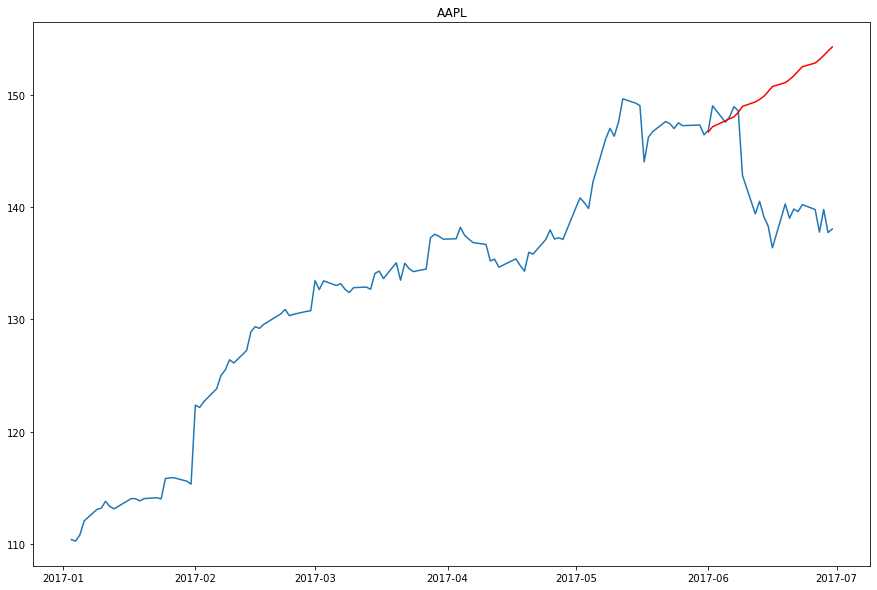

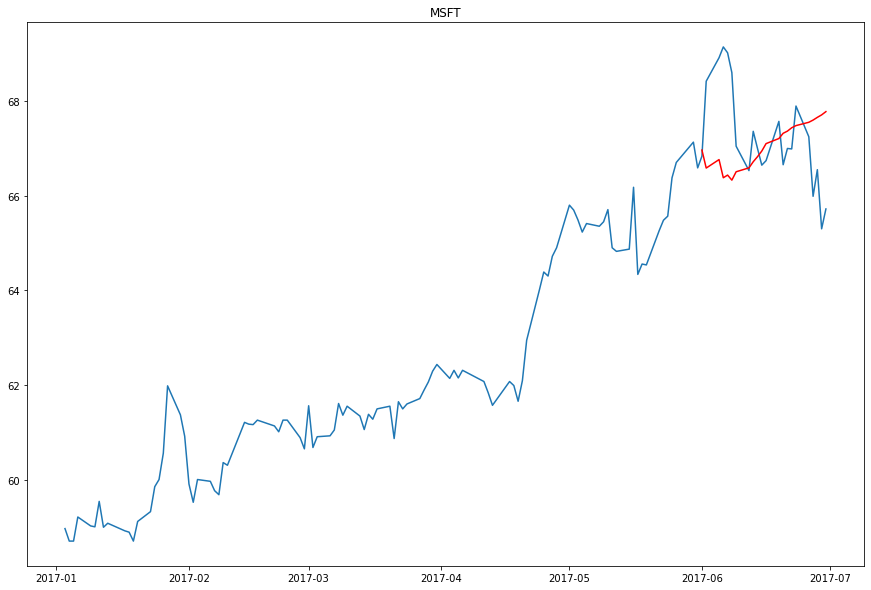

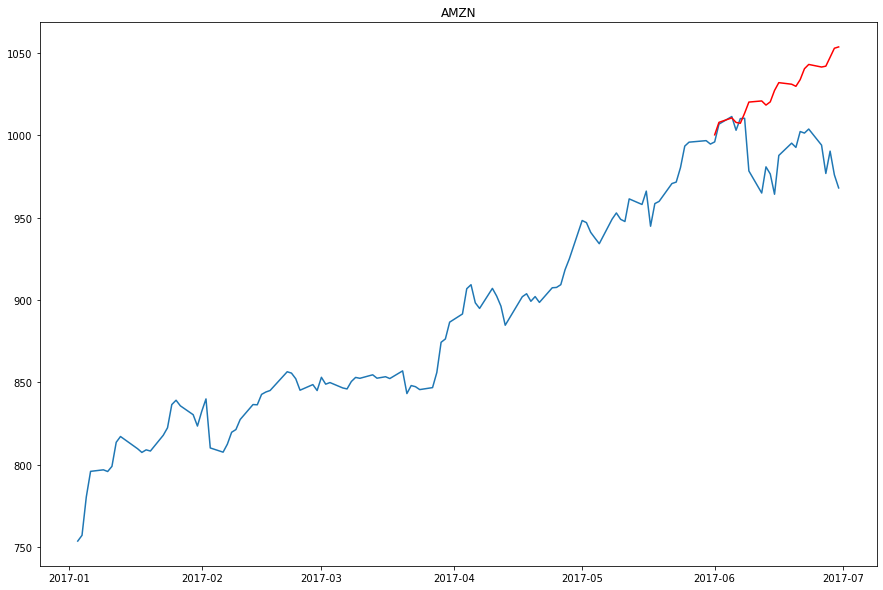

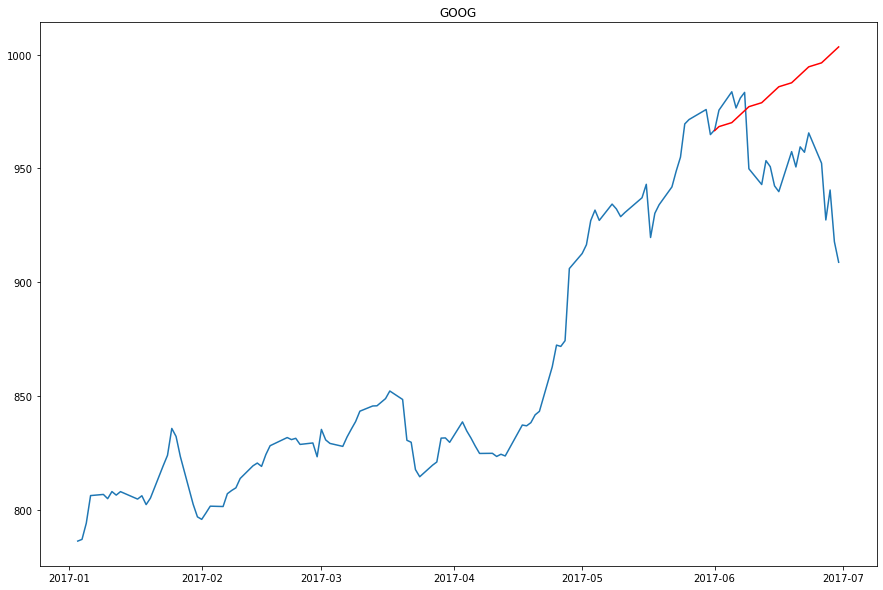

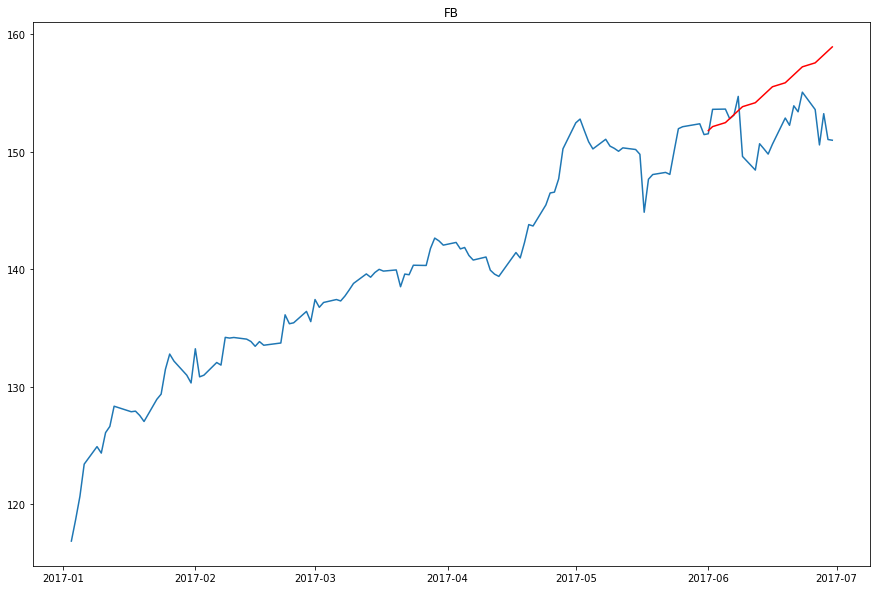

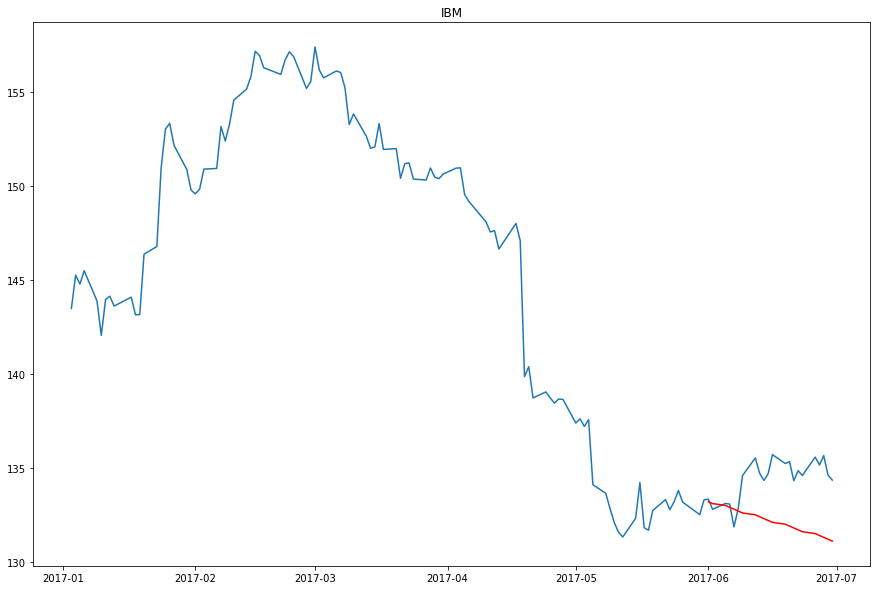

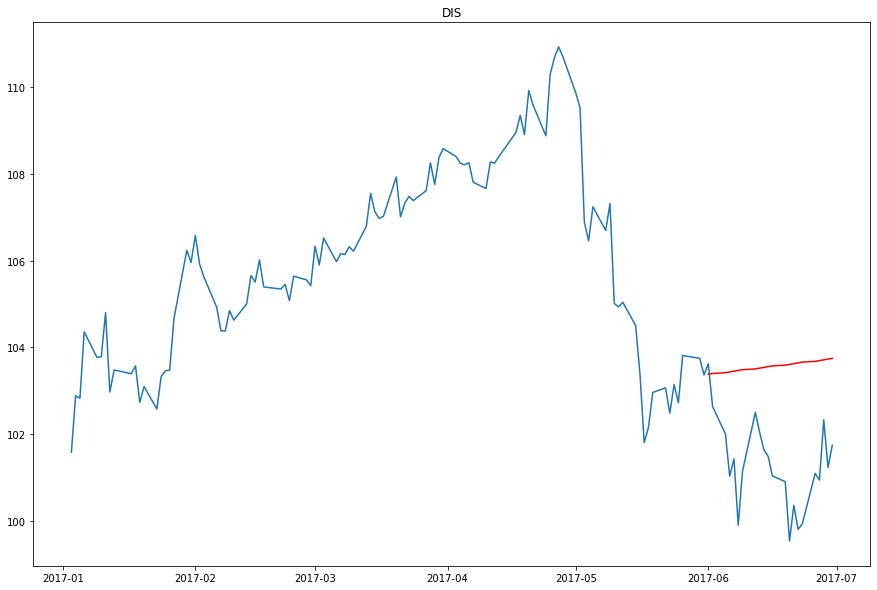

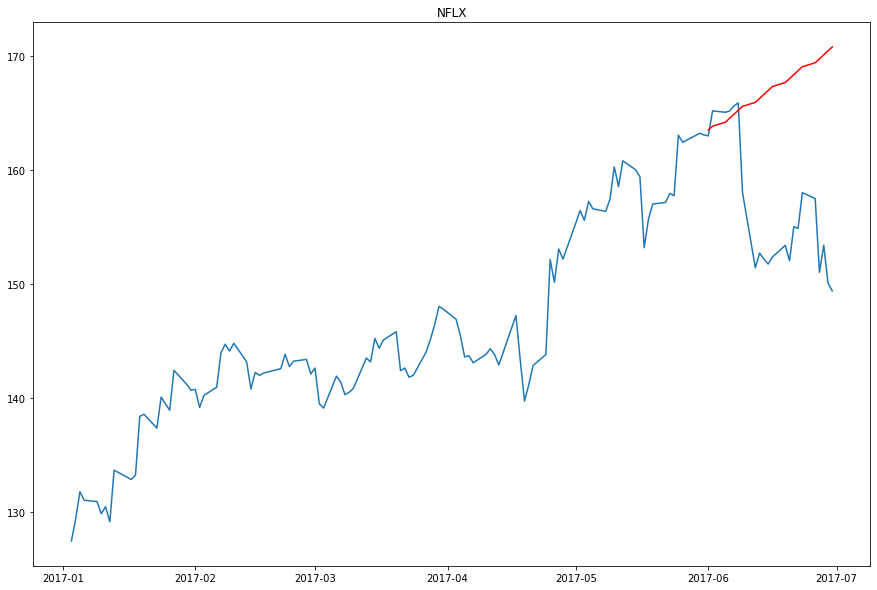

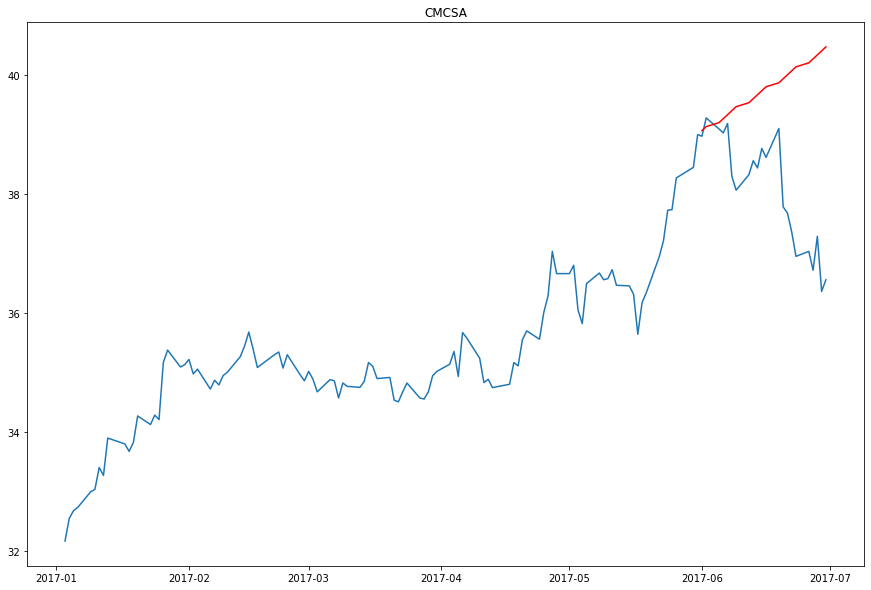

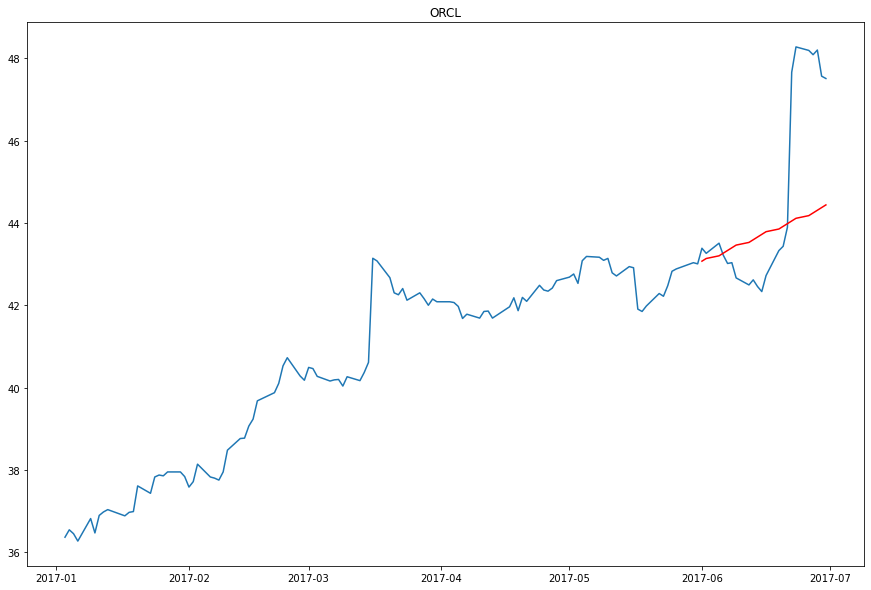

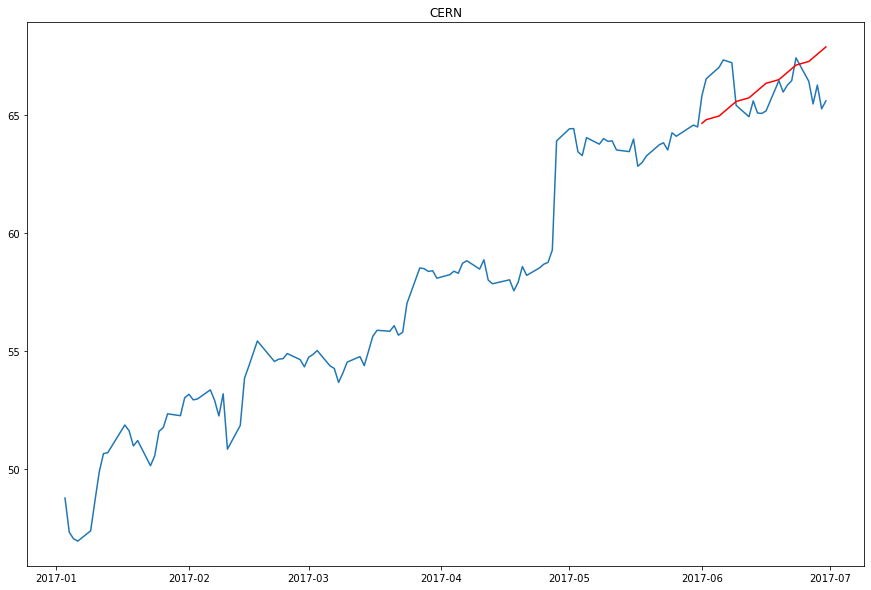

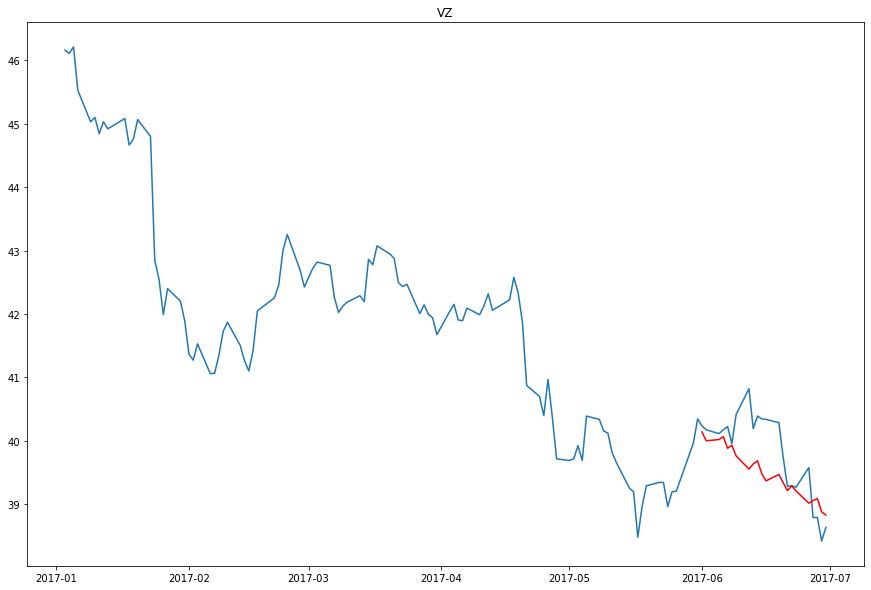

In [22]:
for ticker in tickers:
    plt.figure(figsize=(15,10))
    plt.plot(dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-06-30'])
    plt.plot(dataframes_dict[ticker]['Adj Close']['2017-06-01':'2017-06-30'].index,sarimax_dict_5[ticker].predict(22),color='red')
    plt.title(ticker)

In [23]:
from pytrends import dailydata

In [24]:
aapl_trend = dailydata.get_daily_data('AAPL',2017,1,2017,6)

AAPL:2017-01-01 2017-01-31
AAPL:2017-02-01 2017-02-28
AAPL:2017-03-01 2017-03-31
AAPL:2017-04-01 2017-04-30
AAPL:2017-05-01 2017-05-31
AAPL:2017-06-01 2017-06-30


In [25]:
aapl_trend_train = aapl_trend.loc[dataframes_dict['AAPL']['Adj Close']['2017-01-01':'2017-05-31'].index]['AAPL']

In [26]:
msft_trend = dailydata.get_daily_data('MSFT',2017,1,2017,6)

MSFT:2017-01-01 2017-01-31
MSFT:2017-02-01 2017-02-28
MSFT:2017-03-01 2017-03-31
MSFT:2017-04-01 2017-04-30
MSFT:2017-05-01 2017-05-31
MSFT:2017-06-01 2017-06-30


In [27]:
msft_trend_train = msft_trend.loc[dataframes_dict['MSFT']['Adj Close']['2017-01-01':'2017-05-31'].index]['MSFT']

In [28]:
amzn_trend = dailydata.get_daily_data('AMZN',2017,1,2017,6) 

AMZN:2017-01-01 2017-01-31
AMZN:2017-02-01 2017-02-28
AMZN:2017-03-01 2017-03-31
AMZN:2017-04-01 2017-04-30
AMZN:2017-05-01 2017-05-31
AMZN:2017-06-01 2017-06-30


In [29]:
amzn_trend_train = amzn_trend.loc[dataframes_dict['AMZN']['Adj Close']['2017-01-01':'2017-05-31'].index]['AMZN']

In [31]:
goog_trend = dailydata.get_daily_data('GOOG',2017,1,2017,6)

GOOG:2017-01-01 2017-01-31
GOOG:2017-02-01 2017-02-28
GOOG:2017-03-01 2017-03-31
GOOG:2017-04-01 2017-04-30
GOOG:2017-05-01 2017-05-31
GOOG:2017-06-01 2017-06-30


In [32]:
goog_trend_train = goog_trend.loc[dataframes_dict['GOOG']['Adj Close']['2017-01-01':'2017-05-31'].index]['GOOG']

In [33]:
fb_trend = dailydata.get_daily_data('FB',2017,1,2017,6) 

FB:2017-01-01 2017-01-31
FB:2017-02-01 2017-02-28
FB:2017-03-01 2017-03-31
FB:2017-04-01 2017-04-30
FB:2017-05-01 2017-05-31
FB:2017-06-01 2017-06-30


In [34]:
fb_trend_train = fb_trend.loc[dataframes_dict['FB']['Adj Close']['2017-01-01':'2017-05-31'].index]['FB']

In [35]:
ibm_trend = dailydata.get_daily_data('IBM',2017,1,2017,6) 

IBM:2017-01-01 2017-01-31
IBM:2017-02-01 2017-02-28
IBM:2017-03-01 2017-03-31
IBM:2017-04-01 2017-04-30
IBM:2017-05-01 2017-05-31
IBM:2017-06-01 2017-06-30


In [36]:
ibm_trend_train = ibm_trend.loc[dataframes_dict['IBM']['Adj Close']['2017-01-01':'2017-05-31'].index]['IBM']

In [37]:
dis_trend = dailydata.get_daily_data('DIS',2017,1,2017,6) 

DIS:2017-01-01 2017-01-31
DIS:2017-02-01 2017-02-28
DIS:2017-03-01 2017-03-31
DIS:2017-04-01 2017-04-30
DIS:2017-05-01 2017-05-31
DIS:2017-06-01 2017-06-30


In [38]:
dis_trend_train = dis_trend.loc[dataframes_dict['DIS']['Adj Close']['2017-01-01':'2017-05-31'].index]['DIS']

In [39]:
nflx_trend = dailydata.get_daily_data('NFLX',2017,1,2017,6) 

NFLX:2017-01-01 2017-01-31
NFLX:2017-02-01 2017-02-28
NFLX:2017-03-01 2017-03-31
NFLX:2017-04-01 2017-04-30
NFLX:2017-05-01 2017-05-31
NFLX:2017-06-01 2017-06-30


In [40]:
nflx_trend_train = nflx_trend.loc[dataframes_dict['NFLX']['Adj Close']['2017-01-01':'2017-05-31'].index]['NFLX']

In [41]:
cmcsa_trend = dailydata.get_daily_data('CMCSA',2017,1,2017,6) 

CMCSA:2017-01-01 2017-01-31
CMCSA:2017-02-01 2017-02-28
CMCSA:2017-03-01 2017-03-31
CMCSA:2017-04-01 2017-04-30
CMCSA:2017-05-01 2017-05-31
CMCSA:2017-06-01 2017-06-30


In [42]:
cmcsa_trend_train = cmcsa_trend.loc[dataframes_dict['CMCSA']['Adj Close']['2017-01-01':'2017-05-31'].index]['CMCSA']

In [43]:
orcl_trend = dailydata.get_daily_data('ORCL',2017,1,2017,6) 

ORCL:2017-01-01 2017-01-31
ORCL:2017-02-01 2017-02-28
ORCL:2017-03-01 2017-03-31
ORCL:2017-04-01 2017-04-30
ORCL:2017-05-01 2017-05-31
ORCL:2017-06-01 2017-06-30


In [44]:
orcl_trend_train = orcl_trend.loc[dataframes_dict['ORCL']['Adj Close']['2017-01-01':'2017-05-31'].index]['ORCL']

In [45]:
cern_trend = dailydata.get_daily_data('CERN',2017,1,2017,6) 

CERN:2017-01-01 2017-01-31
CERN:2017-02-01 2017-02-28
CERN:2017-03-01 2017-03-31
CERN:2017-04-01 2017-04-30
CERN:2017-05-01 2017-05-31
CERN:2017-06-01 2017-06-30


In [46]:
cern_trend_train = cern_trend.loc[dataframes_dict['CERN']['Adj Close']['2017-01-01':'2017-05-31'].index]['CERN']

In [47]:
vz_trend = dailydata.get_daily_data('VZ',2017,1,2017,6)

VZ:2017-01-01 2017-01-31
VZ:2017-02-01 2017-02-28
VZ:2017-03-01 2017-03-31
VZ:2017-04-01 2017-04-30
VZ:2017-05-01 2017-05-31
VZ:2017-06-01 2017-06-30


In [48]:
vz_trend_train = vz_trend.loc[dataframes_dict['VZ']['Adj Close']['2017-01-01':'2017-05-31'].index]['VZ']

In [49]:
exogenous_list =  [aapl_trend_train,msft_trend_train,amzn_trend_train,goog_trend_train,fb_trend_train,ibm_trend_train,dis_trend_train,nflx_trend_train,cmcsa_trend_train,orcl_trend_train,cern_trend_train,vz_trend_train]

In [50]:
#Running SARIMAX model on the 5-month data with exogenous google trends data
sarimax_dict_5_exog = {}
i = 0
for ticker in tickers:
    model = pm.auto_arima(dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-05-31'],X=exogenous_list[i].reset_index().drop('Date',axis=1),start_p=1,d=1,start_q=1,max_p=10,max_q=10,max_order=10,information_criterion='aic',stepwise=False)
    sarimax_dict_5_exog[ticker] = model
    i+=1

In [51]:
for ticker in tickers:
    print(ticker,sarimax_dict_5_exog[ticker],sarimax_dict_5_exog[ticker].aic())

AAPL  ARIMA(2,1,3)(0,0,0)[1] intercept 338.71968172827053
MSFT  ARIMA(0,1,8)(0,0,0)[1] intercept 129.4375664102164
AMZN  ARIMA(6,1,1)(0,0,0)[1] intercept 719.104952956856
GOOG  ARIMA(1,1,0)(0,0,0)[1] intercept 695.4142440888187
FB  ARIMA(0,1,0)(0,0,0)[1] intercept 323.4152262039045
IBM  ARIMA(0,1,0)(0,0,0)[1] intercept 350.670849037
DIS  ARIMA(0,1,0)(0,0,0)[1] intercept 225.07514563856842
NFLX  ARIMA(1,1,0)(0,0,0)[1] intercept 424.39987842161804
CMCSA  ARIMA(0,1,0)(0,0,0)[1] intercept 45.989542685370516
ORCL  ARIMA(0,1,0)(0,0,0)[1] intercept 74.77728845316763
CERN  ARIMA(1,1,4)(0,0,0)[1] intercept 237.10107025389183
VZ  ARIMA(2,1,2)(0,0,0)[1] intercept 95.98620842804176


In [52]:
residuals_5_exog = []
for ticker in tickers:
    residuals = sarimax_dict_5_exog[ticker].resid()
    residuals_5_exog.append(np.mean(np.abs(residuals)))
    print(ticker,'MAE of the resdiuals',np.mean(np.abs(residuals)))
residuals_5_exog = np.array(residuals_5_exog)

AAPL MAE of the resdiuals 1.8505918154957632
MSFT MAE of the resdiuals 0.8760664247800675
AMZN MAE of the resdiuals 12.703824642704607
GOOG MAE of the resdiuals 12.2955343717958
FB MAE of the resdiuals 1.9622485597419577
IBM MAE of the resdiuals 2.2988872688182984
DIS MAE of the resdiuals 1.5056824948680738
NFLX MAE of the resdiuals 2.5634469411547953
CMCSA MAE of the resdiuals 0.5399644210391149
ORCL MAE of the resdiuals 0.5651758453410697
CERN MAE of the resdiuals 0.9351179118795359
VZ MAE of the resdiuals 0.7210900809187513


In [56]:
aapl_trend_test = aapl_trend.loc[dataframes_dict['AAPL']['Adj Close']['2017-06-01':'2017-06-30'].index]['AAPL']
msft_trend_test = msft_trend.loc[dataframes_dict['MSFT']['Adj Close']['2017-06-01':'2017-06-30'].index]['MSFT']
amzn_trend_test = amzn_trend.loc[dataframes_dict['AMZN']['Adj Close']['2017-06-01':'2017-06-30'].index]['AMZN']
goog_trend_test = goog_trend.loc[dataframes_dict['GOOG']['Adj Close']['2017-06-01':'2017-06-30'].index]['GOOG']
fb_trend_test = fb_trend.loc[dataframes_dict['FB']['Adj Close']['2017-06-01':'2017-06-30'].index]['FB']
ibm_trend_test = ibm_trend.loc[dataframes_dict['IBM']['Adj Close']['2017-06-01':'2017-06-30'].index]['IBM']
dis_trend_test = dis_trend.loc[dataframes_dict['DIS']['Adj Close']['2017-06-01':'2017-06-30'].index]['DIS']
nflx_trend_test = nflx_trend.loc[dataframes_dict['NFLX']['Adj Close']['2017-06-01':'2017-06-30'].index]['NFLX']
cmcsa_trend_test = cmcsa_trend.loc[dataframes_dict['CMCSA']['Adj Close']['2017-06-01':'2017-06-30'].index]['CMCSA']
orcl_trend_test = orcl_trend.loc[dataframes_dict['ORCL']['Adj Close']['2017-06-01':'2017-06-30'].index]['ORCL']
cern_trend_test = cern_trend.loc[dataframes_dict['CERN']['Adj Close']['2017-06-01':'2017-06-30'].index]['CERN']
vz_trend_test = vz_trend.loc[dataframes_dict['VZ']['Adj Close']['2017-06-01':'2017-06-30'].index]['VZ']

In [57]:
exogenous_list_test =  [aapl_trend_test,msft_trend_test,amzn_trend_test,goog_trend_test,fb_trend_test,ibm_trend_test,dis_trend_test,nflx_trend_test,cmcsa_trend_test,orcl_trend_test,cern_trend_test,vz_trend_test]

In [58]:
mape_5_exog = []
i = 0
for ticker in tickers:
    mape = smape(dataframes_dict[ticker]['Adj Close']['2017-06-01':'2017-06-30'],sarimax_dict_5_exog[ticker].predict(22,X=exogenous_list_test[i].reset_index().drop('Date',axis=1)))
    mape_5_exog.append(mape)
    print(ticker,'MAPE of',mape)
    i+=1

AAPL MAPE of 6.434073899096322
MSFT MAPE of 1.4830616768387919
AMZN MAPE of 2.8318407415378193
GOOG MAPE of 3.4955833017460076
FB MAPE of 2.4723950904975722
IBM MAPE of 1.7495960972455171
DIS MAPE of 2.2450830818741596
NFLX MAPE of 6.844848140250895
CMCSA MAPE of 4.452361798560937
ORCL MAPE of 3.4831753173361757
CERN MAPE of 1.9023631232875764
VZ MAPE of 0.8984559522381038


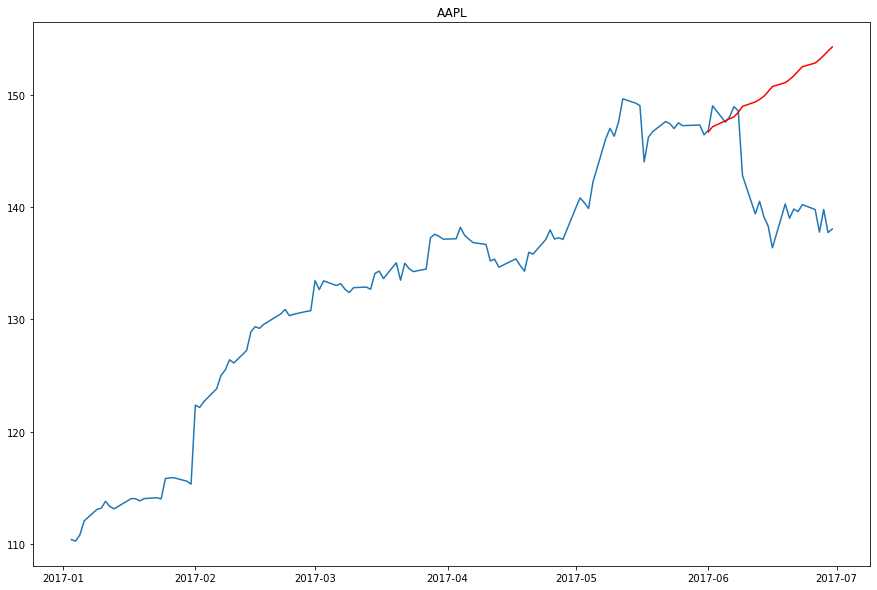

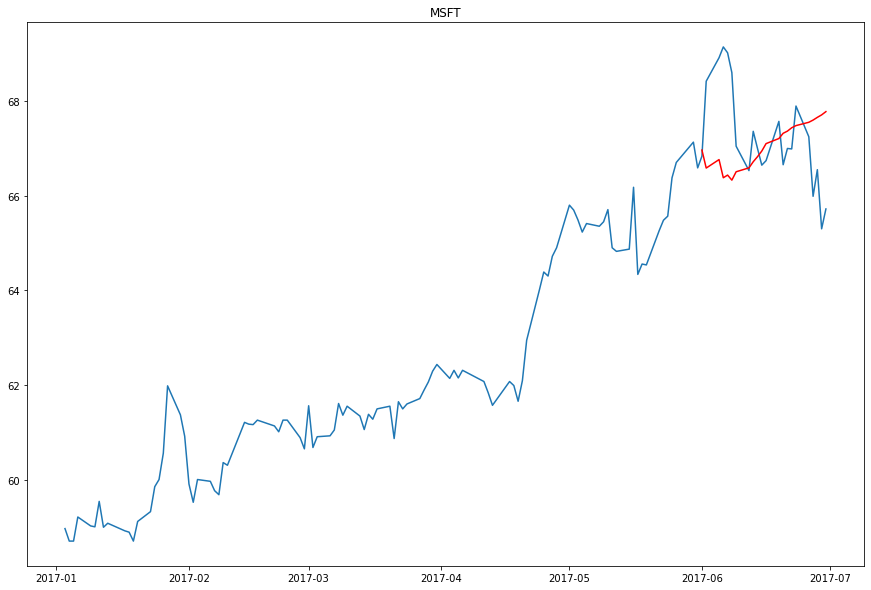

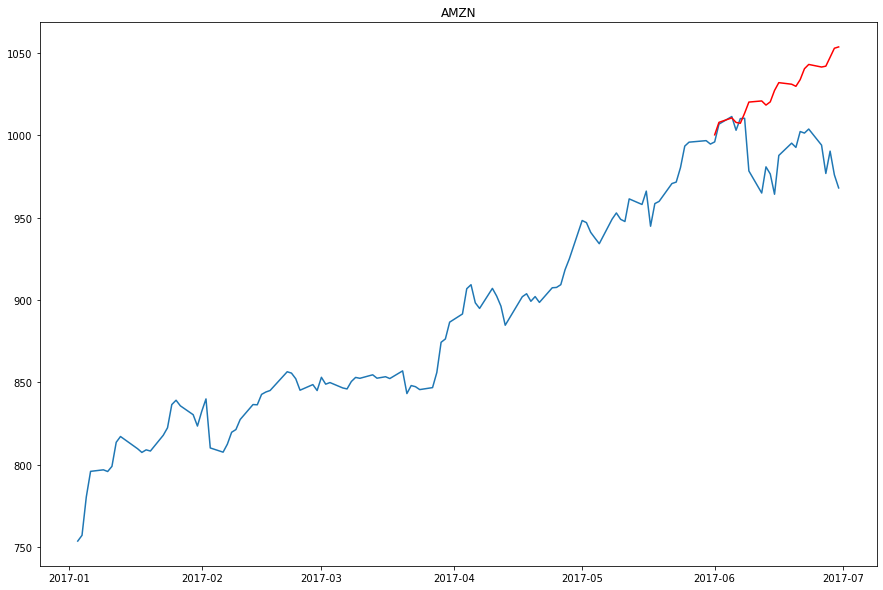

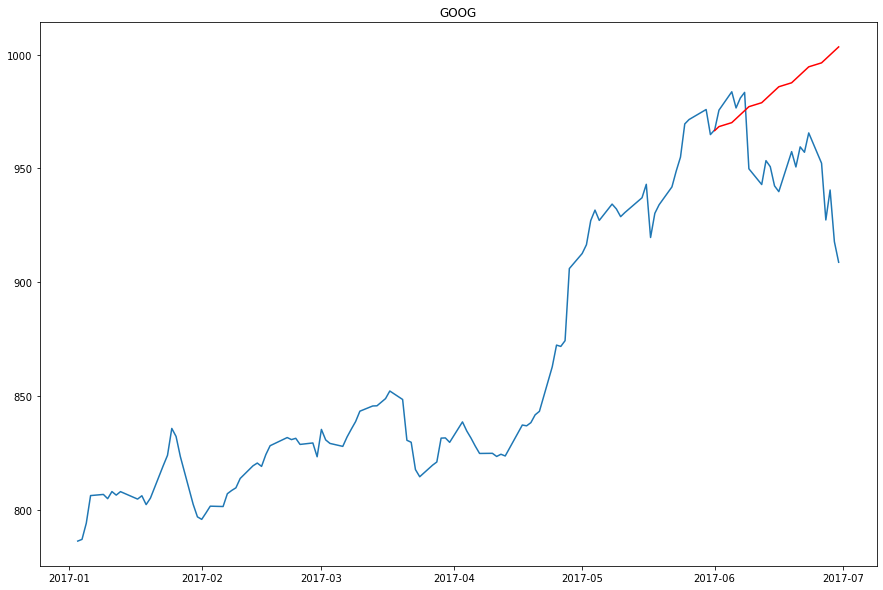

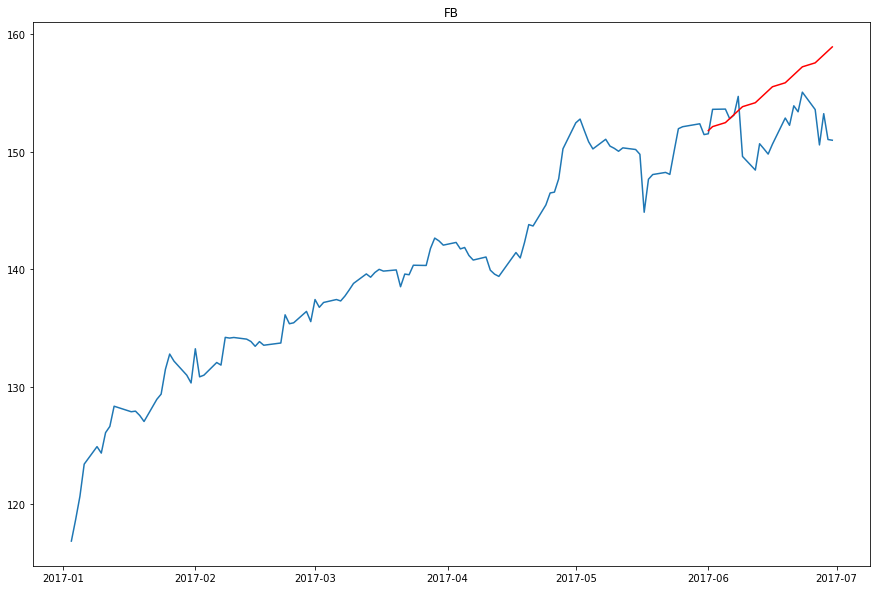

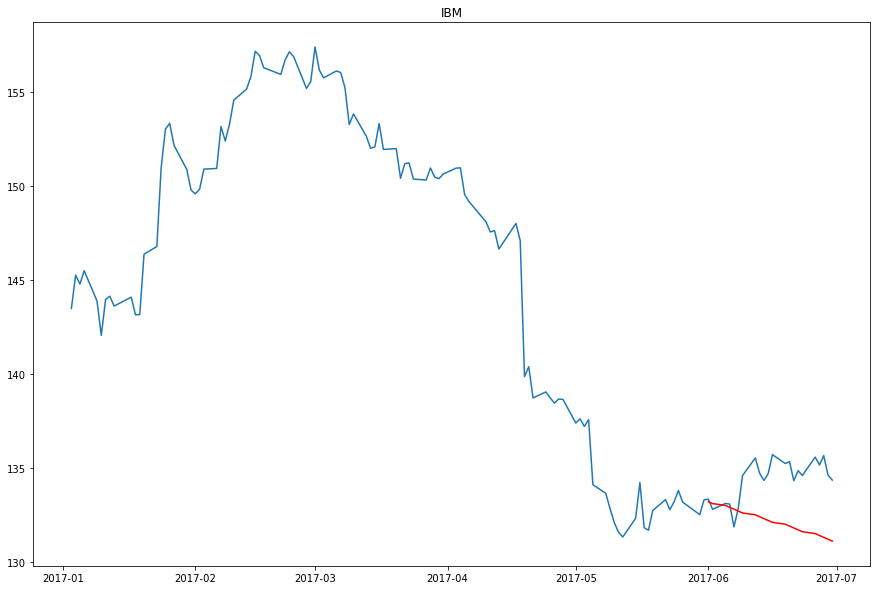

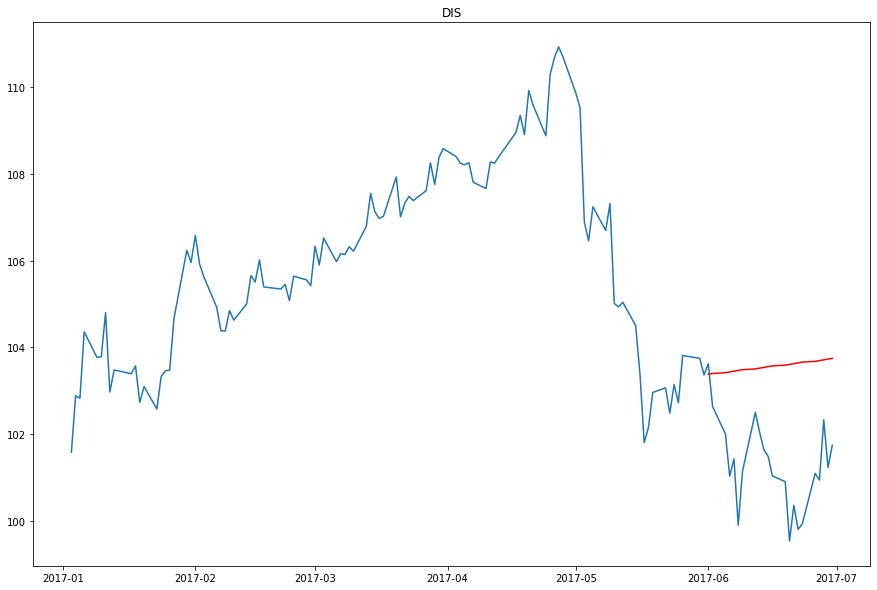

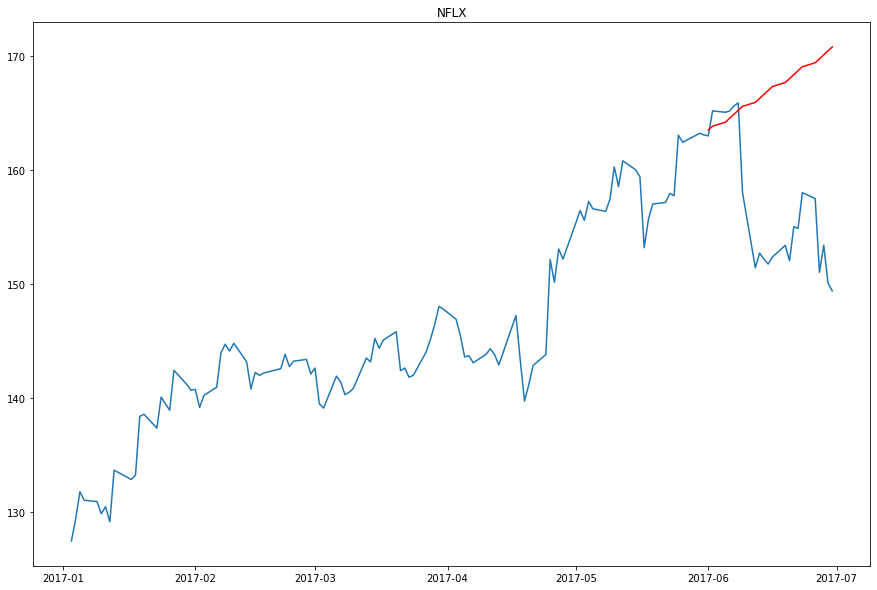

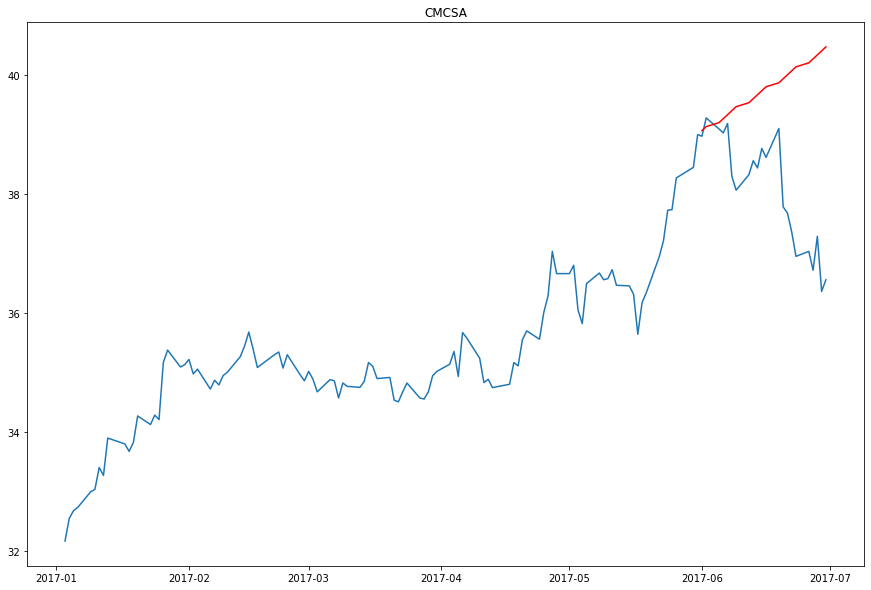

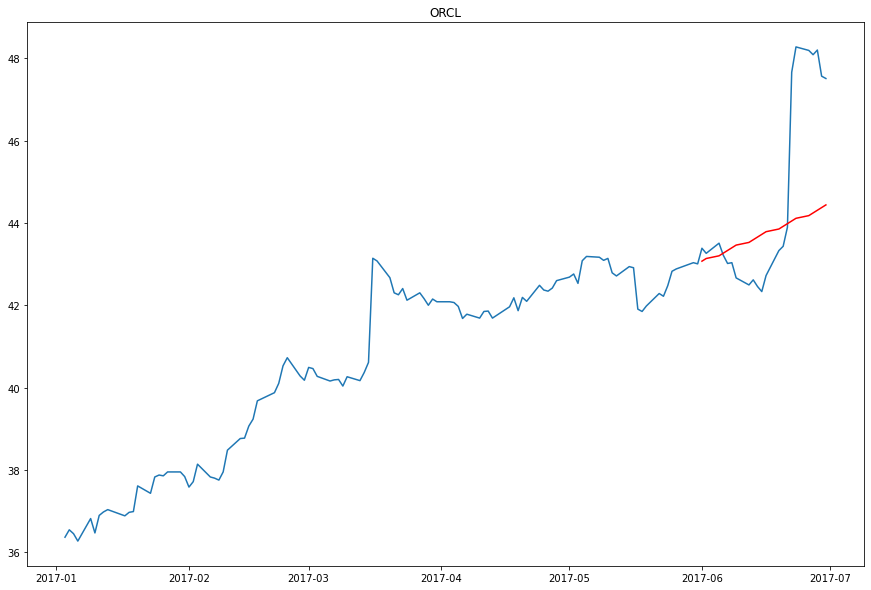

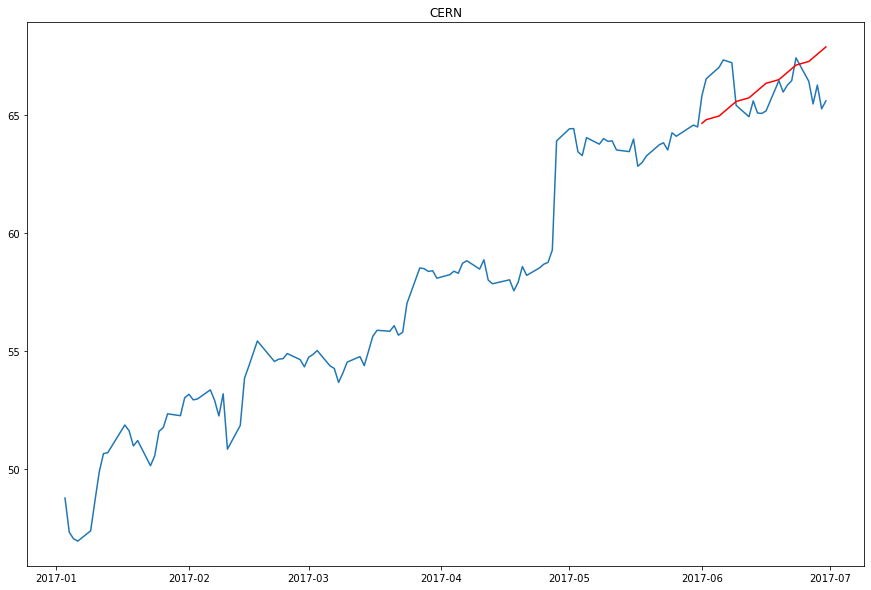

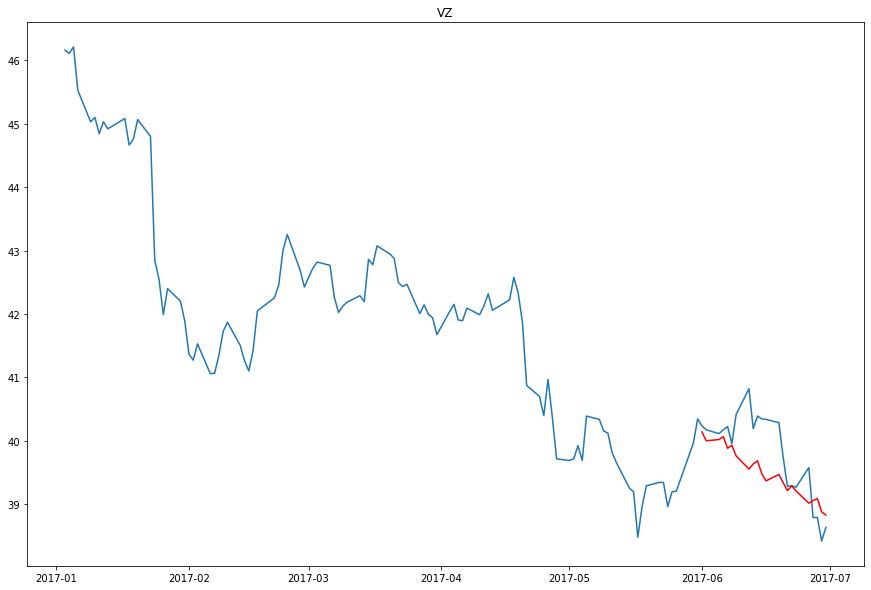

In [59]:
i = 0
for ticker in tickers:
    plt.figure(figsize=(15,10))
    plt.plot(dataframes_dict[ticker]['Adj Close']['2017-01-01':'2017-06-30'])
    plt.plot(dataframes_dict[ticker]['Adj Close']['2017-06-01':'2017-06-30'].index,sarimax_dict_5[ticker].predict(22,X=exogenous_list_test[i].reset_index().drop('Date',axis=1)),color='red')
    plt.title(ticker)
    i+=1

In [60]:
from prophet import Prophet

In [61]:
aapl_m =  Prophet(daily_seasonality = True)
msft_m =  Prophet(daily_seasonality = True)
amzn_m =  Prophet(daily_seasonality = True)
goog_m =  Prophet(daily_seasonality = True) 
fb_m =  Prophet(daily_seasonality = True)
ibm_m =  Prophet(daily_seasonality = True)
dis_m =  Prophet(daily_seasonality = True)
nflx_m =  Prophet(daily_seasonality = True)
cmcsa_m =  Prophet(daily_seasonality = True)
orcl_m =  Prophet(daily_seasonality = True)
cern_m =  Prophet(daily_seasonality = True)
vz_m =  Prophet(daily_seasonality = True)

In [62]:
aapl_m.fit(dataframes_dict['AAPL']['Adj Close']['2017-01-01':'2017-12-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
msft_m.fit(dataframes_dict['MSFT']['Adj Close']['2017-01-01':'2017-12-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
amzn_m.fit(dataframes_dict['AMZN']['Adj Close']['2017-01-01':'2017-12-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
goog_m.fit(dataframes_dict['GOOG']['Adj Close']['2017-01-01':'2017-12-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
fb_m.fit(dataframes_dict['FB']['Adj Close']['2017-01-01':'2017-12-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
ibm_m.fit(dataframes_dict['IBM']['Adj Close']['2017-01-01':'2017-12-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
dis_m.fit(dataframes_dict['DIS']['Adj Close']['2017-01-01':'2017-12-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
nflx_m.fit(dataframes_dict['NFLX']['Adj Close']['2017-01-01':'2017-12-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
cmcsa_m.fit(dataframes_dict['CMCSA']['Adj Close']['2017-01-01':'2017-12-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
orcl_m.fit(dataframes_dict['ORCL']['Adj Close']['2017-01-01':'2017-12-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
cern_m.fit(dataframes_dict['CERN']['Adj Close']['2017-01-01':'2017-12-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
vz_m.fit(dataframes_dict['VZ']['Adj Close']['2017-01-01':'2017-12-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

In [63]:
aapl_future = aapl_m.make_future_dataframe(periods=154)
msft_future = msft_m.make_future_dataframe(periods=154)
amzn_future = amzn_m.make_future_dataframe(periods=154)
goog_future = goog_m.make_future_dataframe(periods=154)
fb_future = fb_m.make_future_dataframe(periods=154)
ibm_future = ibm_m.make_future_dataframe(periods=154)
dis_future = dis_m.make_future_dataframe(periods=154)
nflx_future = nflx_m.make_future_dataframe(periods=154)
cmcsa_future = cmcsa_m.make_future_dataframe(periods=154)
orcl_future = orcl_m.make_future_dataframe(periods=154)
cern_future = cern_m.make_future_dataframe(periods=154)
vz_future = vz_m.make_future_dataframe(periods=154)

In [64]:
aapl_forecast = aapl_m.predict(aapl_future)
msft_forecast = msft_m.predict(msft_future)
amzn_forecast = amzn_m.predict(amzn_future)
goog_forecast = goog_m.predict(goog_future)
fb_forecast = fb_m.predict(fb_future)
ibm_forecast = ibm_m.predict(ibm_future)
dis_forecast = dis_m.predict(dis_future)
nflx_forecast = nflx_m.predict(nflx_future)
cmcsa_forecast = cmcsa_m.predict(cmcsa_future)
orcl_forecast = orcl_m.predict(orcl_future)
cern_forecast = cern_m.predict(cern_future)
vz_forecast = vz_m.predict(vz_future)

In [65]:
from prophet.plot import plot_plotly, plot_components_plotly

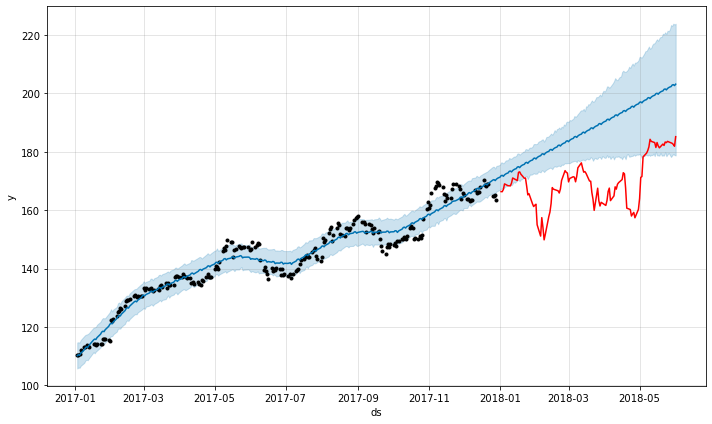

In [66]:
aapl_m.plot(aapl_forecast)
plt.plot(dataframes_dict['AAPL']['Adj Close']['2018-01-01':'2018-06-01'],color='red')

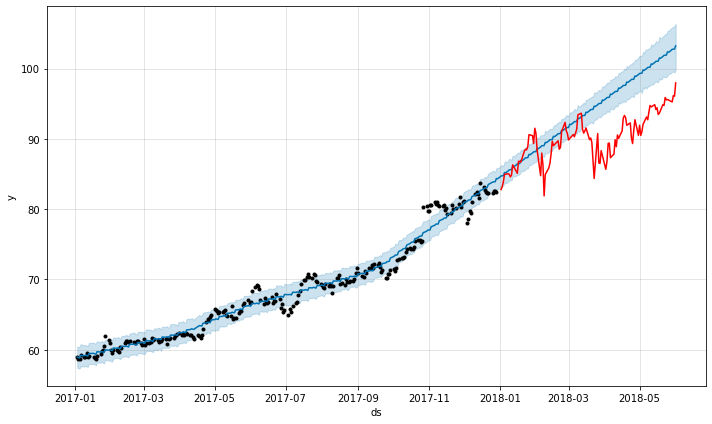

In [67]:
msft_m.plot(msft_forecast)
plt.plot(dataframes_dict['MSFT']['Adj Close']['2018-01-01':'2018-06-01'],color='red')

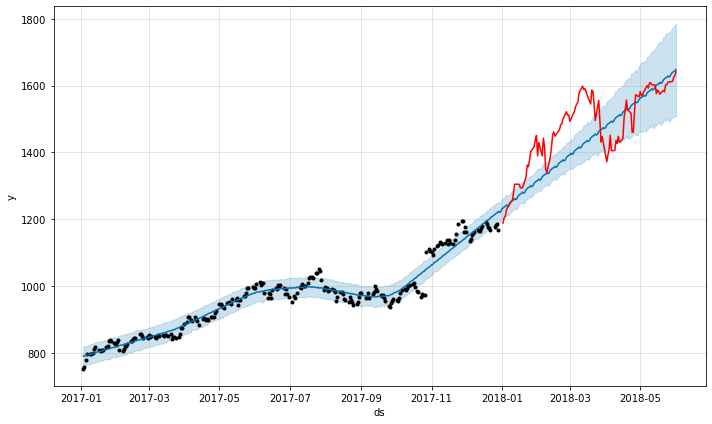

In [68]:
amzn_m.plot(amzn_forecast)
plt.plot(dataframes_dict['AMZN']['Adj Close']['2018-01-01':'2018-06-01'],color='red')

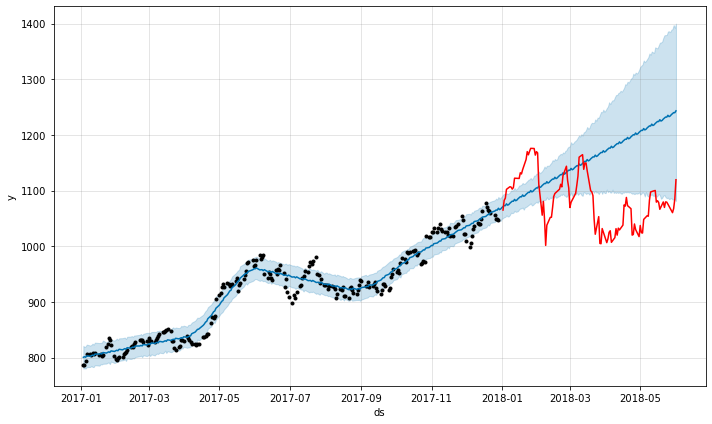

In [69]:
goog_m.plot(goog_forecast)
plt.plot(dataframes_dict['GOOG']['Adj Close']['2018-01-01':'2018-06-01'],color='red')

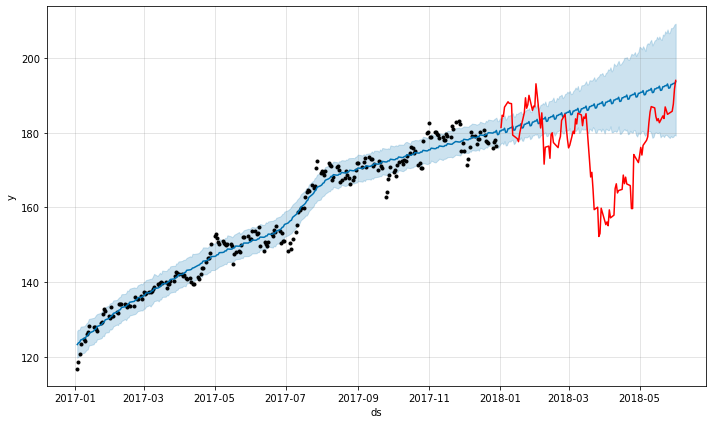

In [70]:
fb_m.plot(fb_forecast)
plt.plot(dataframes_dict['FB']['Adj Close']['2018-01-01':'2018-06-01'],color='red')

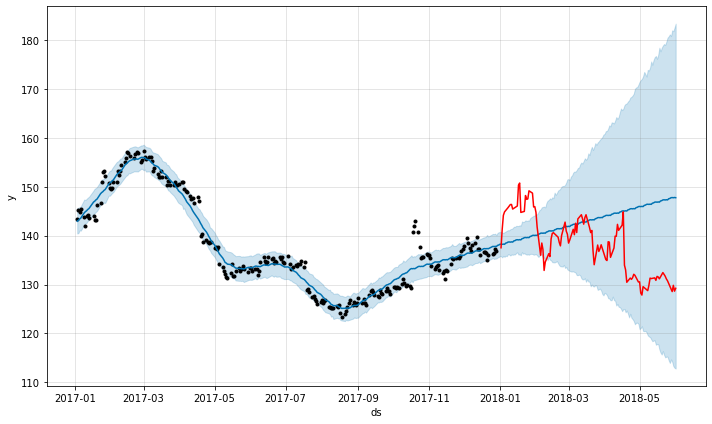

In [71]:
ibm_m.plot(ibm_forecast)
plt.plot(dataframes_dict['IBM']['Adj Close']['2018-01-01':'2018-06-01'],color='red')

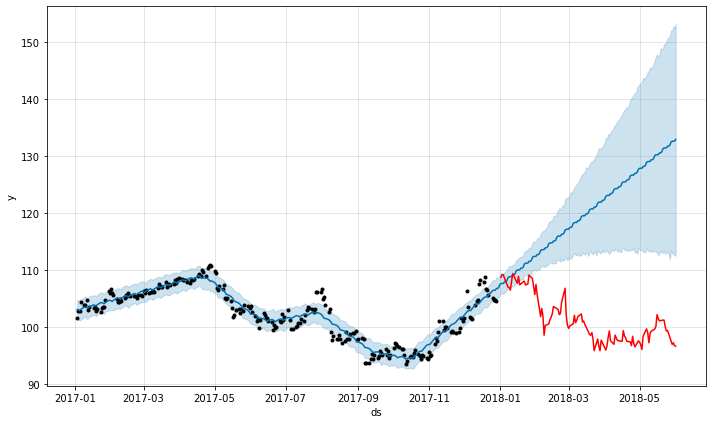

In [72]:
dis_m.plot(dis_forecast)
plt.plot(dataframes_dict['DIS']['Adj Close']['2018-01-01':'2018-06-01'],color='red')

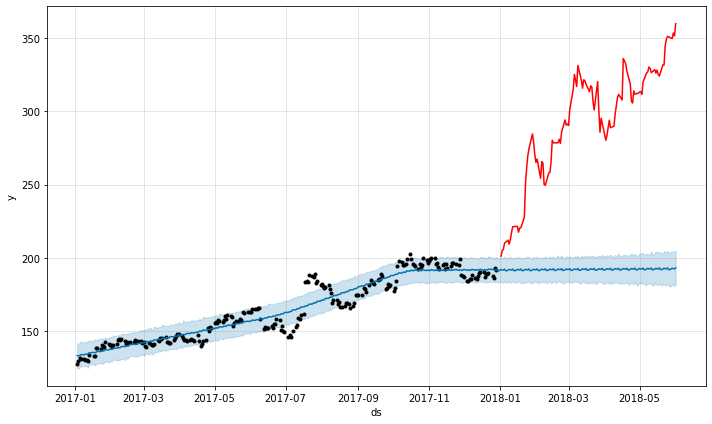

In [73]:
nflx_m.plot(nflx_forecast)
plt.plot(dataframes_dict['NFLX']['Adj Close']['2018-01-01':'2018-06-01'],color='red')

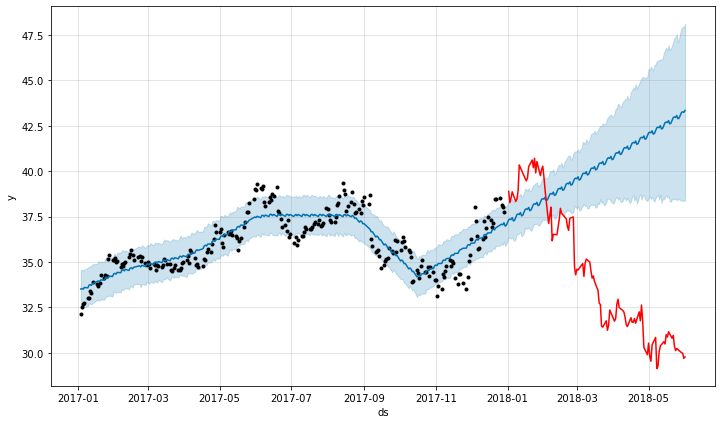

In [74]:
cmcsa_m.plot(cmcsa_forecast)
plt.plot(dataframes_dict['CMCSA']['Adj Close']['2018-01-01':'2018-06-01'],color='red')

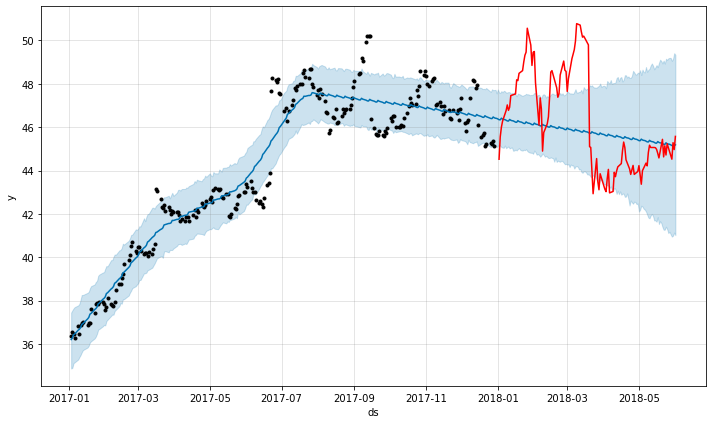

In [75]:
orcl_m.plot(orcl_forecast)
plt.plot(dataframes_dict['ORCL']['Adj Close']['2018-01-01':'2018-06-01'],color='red')

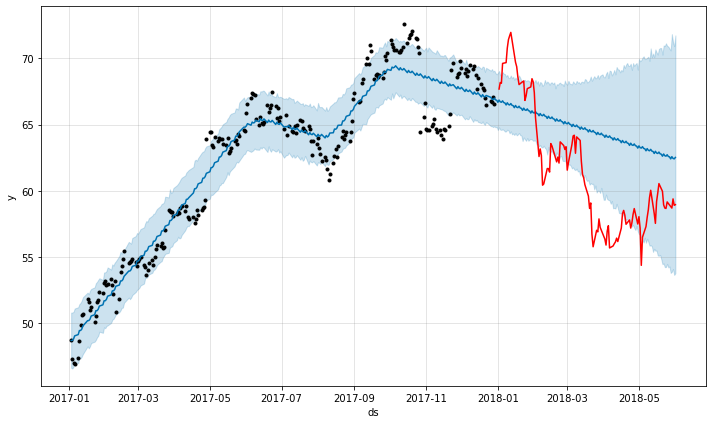

In [76]:
cern_m.plot(cern_forecast)
plt.plot(dataframes_dict['CERN']['Adj Close']['2018-01-01':'2018-06-01'],color='red')

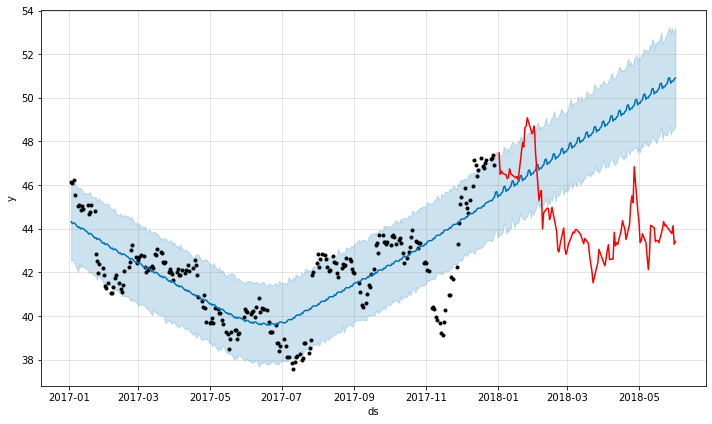

In [77]:
vz_m.plot(vz_forecast)
plt.plot(dataframes_dict['VZ']['Adj Close']['2018-01-01':'2018-06-01'],color='red')

In [78]:
aapl_m5 =  Prophet(daily_seasonality = True)
msft_m5 =  Prophet(daily_seasonality = True)
amzn_m5 =  Prophet(daily_seasonality = True)
goog_m5 =  Prophet(daily_seasonality = True) 
fb_m5 =  Prophet(daily_seasonality = True)
ibm_m5 =  Prophet(daily_seasonality = True)
dis_m5 =  Prophet(daily_seasonality = True)
nflx_m5 =  Prophet(daily_seasonality = True)
cmcsa_m5 =  Prophet(daily_seasonality = True)
orcl_m5 =  Prophet(daily_seasonality = True)
cern_m5 =  Prophet(daily_seasonality = True)
vz_m5 =  Prophet(daily_seasonality = True)

In [79]:
aapl_m5.fit(dataframes_dict['AAPL']['Adj Close']['2017-01-01':'2017-05-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
msft_m5.fit(dataframes_dict['MSFT']['Adj Close']['2017-01-01':'2017-05-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
amzn_m5.fit(dataframes_dict['AMZN']['Adj Close']['2017-01-01':'2017-05-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
goog_m5.fit(dataframes_dict['GOOG']['Adj Close']['2017-01-01':'2017-05-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
fb_m5.fit(dataframes_dict['FB']['Adj Close']['2017-01-01':'2017-05-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
ibm_m5.fit(dataframes_dict['IBM']['Adj Close']['2017-01-01':'2017-05-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
dis_m5.fit(dataframes_dict['DIS']['Adj Close']['2017-01-01':'2017-05-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
nflx_m5.fit(dataframes_dict['NFLX']['Adj Close']['2017-01-01':'2017-05-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
cmcsa_m5.fit(dataframes_dict['CMCSA']['Adj Close']['2017-01-01':'2017-05-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
orcl_m5.fit(dataframes_dict['ORCL']['Adj Close']['2017-01-01':'2017-05-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
cern_m5.fit(dataframes_dict['CERN']['Adj Close']['2017-01-01':'2017-05-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))
vz_m5.fit(dataframes_dict['VZ']['Adj Close']['2017-01-01':'2017-05-31'].reset_index().rename(columns={'Date':'ds','Adj Close':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

In [80]:
aapl_future5 = aapl_m5.make_future_dataframe(periods=30)
msft_future5 = msft_m5.make_future_dataframe(periods=30)
amzn_future5 = amzn_m5.make_future_dataframe(periods=30)
goog_future5 = goog_m5.make_future_dataframe(periods=30)
fb_future5 = fb_m5.make_future_dataframe(periods=30)
ibm_future5 = ibm_m5.make_future_dataframe(periods=30)
dis_future5 = dis_m5.make_future_dataframe(periods=30)
nflx_future5 = nflx_m5.make_future_dataframe(periods=30)
cmcsa_future5 = cmcsa_m5.make_future_dataframe(periods=30)
orcl_future5 = orcl_m5.make_future_dataframe(periods=30)
cern_future5 = cern_m5.make_future_dataframe(periods=30)
vz_future5 = vz_m5.make_future_dataframe(periods=30)

In [81]:
aapl_forecast5 = aapl_m5.predict(aapl_future5)
msft_forecast5 = msft_m5.predict(msft_future5)
amzn_forecast5 = amzn_m5.predict(amzn_future5)
goog_forecast5 = goog_m5.predict(goog_future5)
fb_forecast5 = fb_m5.predict(fb_future5)
ibm_forecast5 = ibm_m5.predict(ibm_future5)
dis_forecast5 = dis_m5.predict(dis_future5)
nflx_forecast5 = nflx_m5.predict(nflx_future5)
cmcsa_forecast5 = cmcsa_m5.predict(cmcsa_future5)
orcl_forecast5 = orcl_m5.predict(orcl_future5)
cern_forecast5 = cern_m5.predict(cern_future5)
vz_forecast5 = vz_m5.predict(vz_future5)

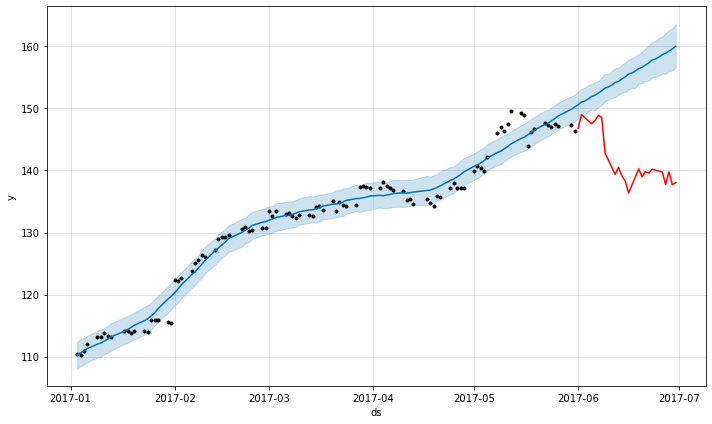

In [82]:
aapl_m5.plot(aapl_forecast5)
plt.plot(dataframes_dict['AAPL']['Adj Close']['2017-06-01':'2017-06-30'],color='red')

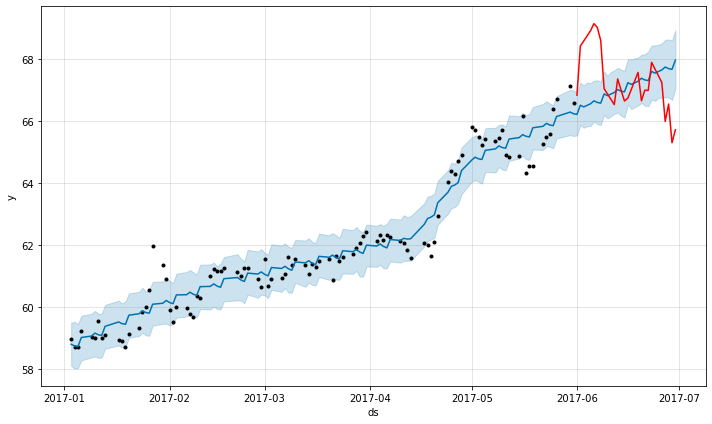

In [83]:
msft_m5.plot(msft_forecast5)
plt.plot(dataframes_dict['MSFT']['Adj Close']['2017-06-01':'2017-06-30'],color='red')

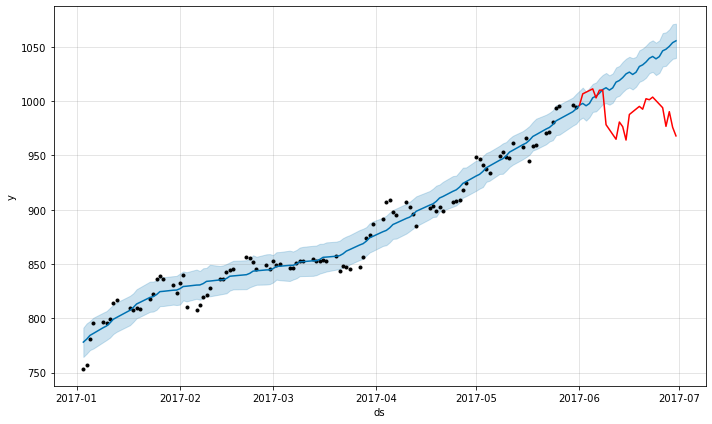

In [84]:
amzn_m5.plot(amzn_forecast5)
plt.plot(dataframes_dict['AMZN']['Adj Close']['2017-06-01':'2017-06-30'],color='red')

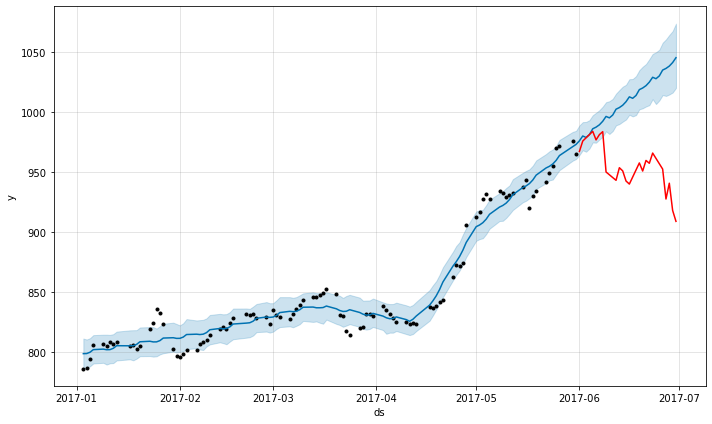

In [85]:
goog_m5.plot(goog_forecast5)
plt.plot(dataframes_dict['GOOG']['Adj Close']['2017-06-01':'2017-06-30'],color='red')

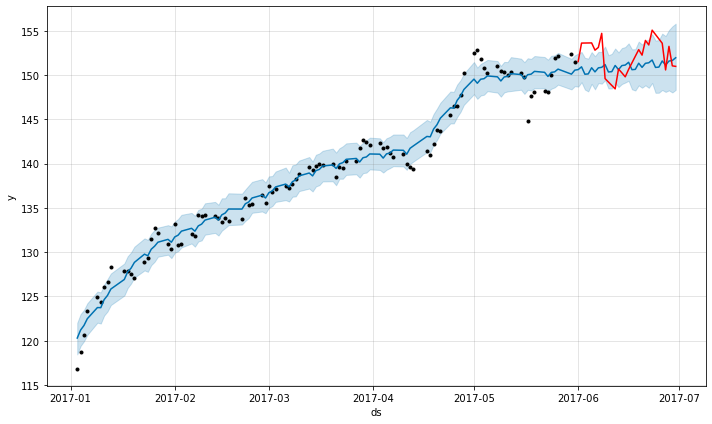

In [86]:
fb_m5.plot(fb_forecast5)
plt.plot(dataframes_dict['FB']['Adj Close']['2017-06-01':'2017-06-30'],color='red')

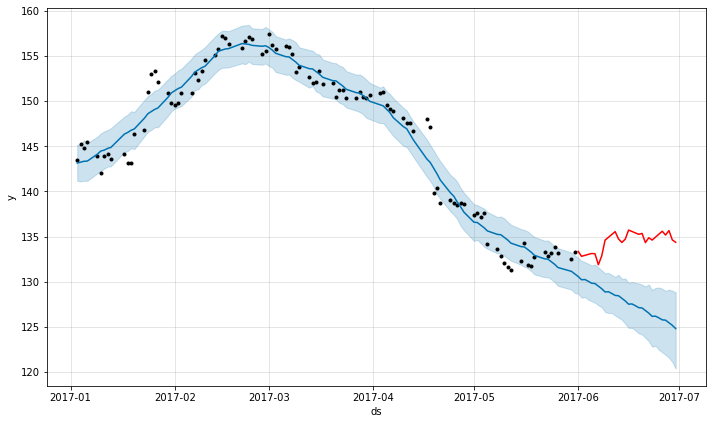

In [87]:
ibm_m5.plot(ibm_forecast5)
plt.plot(dataframes_dict['IBM']['Adj Close']['2017-06-01':'2017-06-30'],color='red')

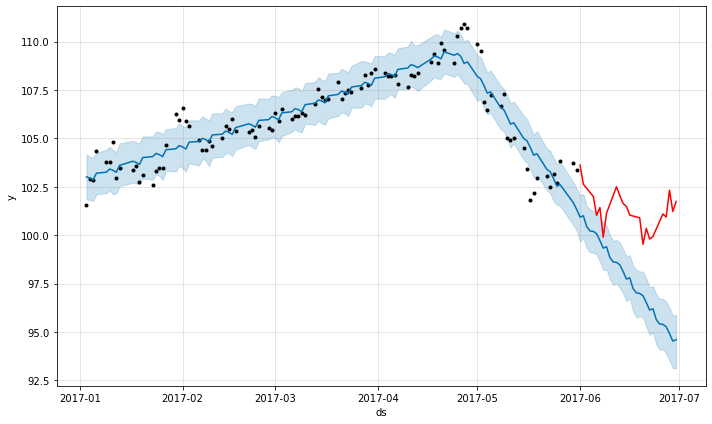

In [88]:
dis_m5.plot(dis_forecast5)
plt.plot(dataframes_dict['DIS']['Adj Close']['2017-06-01':'2017-06-30'],color='red')

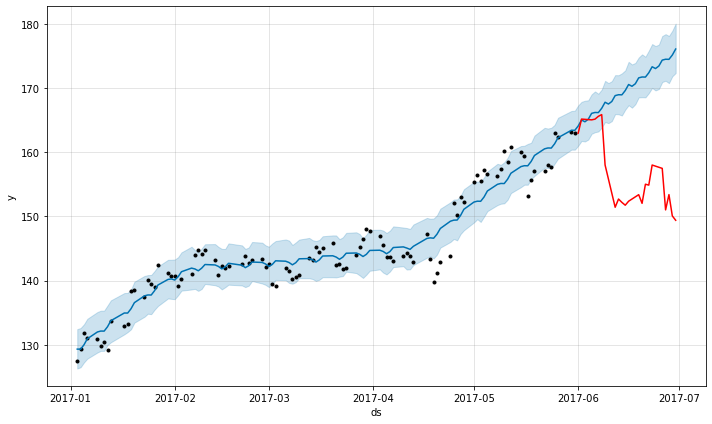

In [89]:
nflx_m5.plot(nflx_forecast5)
plt.plot(dataframes_dict['NFLX']['Adj Close']['2017-06-01':'2017-06-30'],color='red')

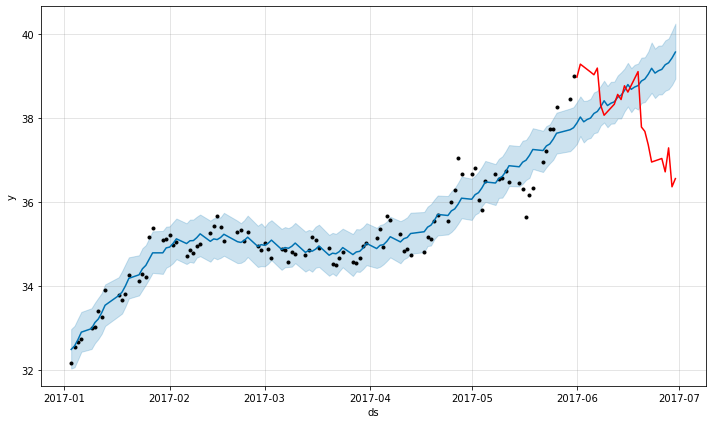

In [90]:
cmcsa_m5.plot(cmcsa_forecast5)
plt.plot(dataframes_dict['CMCSA']['Adj Close']['2017-06-01':'2017-06-30'],color='red')

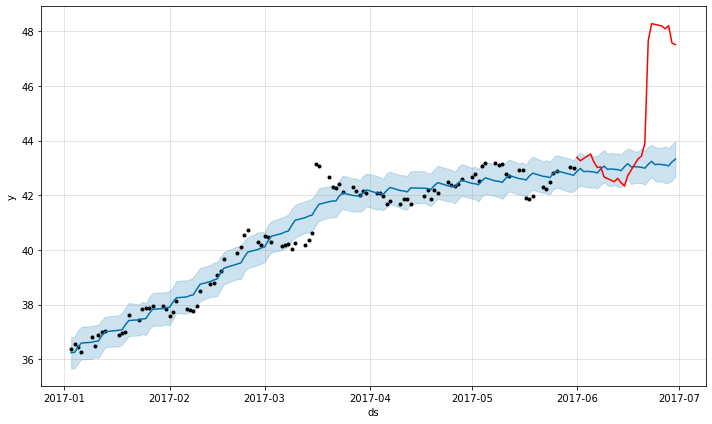

In [91]:
orcl_m5.plot(orcl_forecast5)
plt.plot(dataframes_dict['ORCL']['Adj Close']['2017-06-01':'2017-06-30'],color='red')

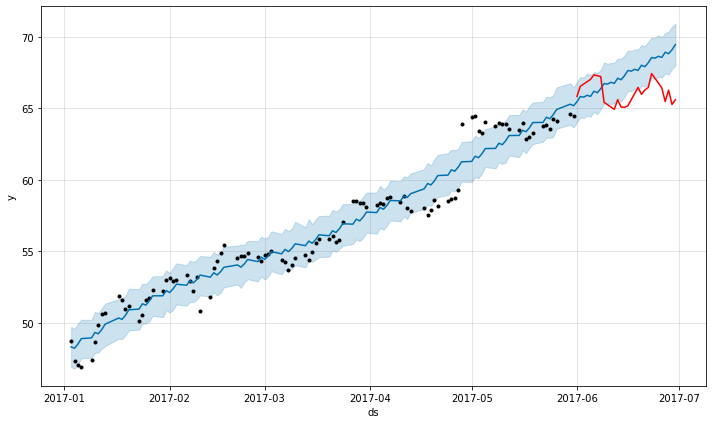

In [92]:
cern_m5.plot(cern_forecast5)
plt.plot(dataframes_dict['CERN']['Adj Close']['2017-06-01':'2017-06-30'],color='red')

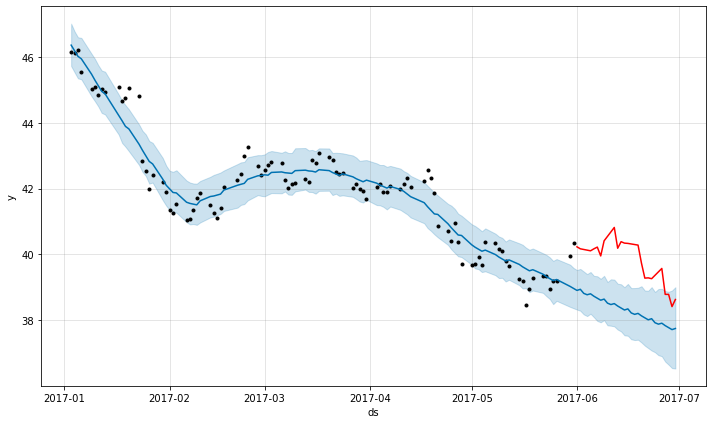

In [93]:
vz_m5.plot(vz_forecast5)
plt.plot(dataframes_dict['VZ']['Adj Close']['2017-06-01':'2017-06-30'],color='red')